In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp # 'sympy' library for symbolic calculations

# Setting the fontsize of x, y label and title of python plots globally
import matplotlib as mpl
# Set global font sizes
mpl.rcParams['axes.titlesize'] = 12      # Title font size
mpl.rcParams['axes.labelsize'] = 12      # X and Y label font size
mpl.rcParams['xtick.labelsize'] = 10     # X tick label font size
mpl.rcParams['ytick.labelsize'] = 10     # Y tick label font size
mpl.rcParams['legend.fontsize'] = 8     # Legend font size
mpl.rcParams['font.size'] = 12           # General font size (e.g. for text)
mpl.rcParams['figure.dpi'] = 300         # higher dpi = more resolution

# For Interactive window (zoom-in, zoom-out feature)
# %matplotlib widget

# Uncomment the below one high quality plots
# plots and code are in same window
%matplotlib inline  
# for clear image, can be set to 'pdf/png' format also
%config InlineBackend.figure_format = 'retina'  

#### Universal constants in SI units ( Global variable )

In [2]:
G = 6.67 * (1e-11)
pc = 3*(1e16)
c = 3*(1e8)

# Mass of Sun in Kg
M_sun = 1e30

#### Binary Masses

In [3]:
# BINARY MASSES

# Primary Mass (bigger BH)
mass_1 = (1e3)*M_sun
# Secondary Mass (smaller BH)
mass_2 = 10*M_sun
# Total mass
total_mass = mass_1 + mass_2

eta = mass_1*mass_2/(total_mass**2)

# ISCO distance
r_min = (6*G*mass_1)/(c**2)

# Conversion factors ( Geometrized units G = c = 1 )
t0 = r_min/c        # from ISCO distance to seconds
l0 = r_min          # from ISCO distance to meters
m0 = (c**2)*r_min/G # from ISCO distance to kg

# Binary masses in ISCO distance (bcz we write DE in geometrized units ,i.e, G = c = 1)
m1 = mass_1 / m0
m2 = mass_2 / m0
M = total_mass / m0

#### Initial orbital parameters

In [4]:
# Initial eccentricity
e_i = 5.0
# Initial value of semi-latus rectum (has NO meaning for hyperbolic orbit but it is related to impact prameter 'b') in ISCO distance
p_i = 100
# Initial value of omega in radians
omega_i = round(np.arccos(-1/e_i),2)
# Staring time
t_i = 0.0

# Distance between binaries and observation point
R = 10 * 1e6 * pc / l0  # in ISCO distance units

#### Hyperbolic orbit 

##### a ) Relation between impact parameter 'b' and 'p'

## <center>$ b = \frac{p}{\sqrt{e^2 - 1}}$</center>

##### b ) Relation between eccentrcity 'e' and $\omega$

## <center>$ e = - \frac{1}{\cos (\omega)}$</center>

##### c ) NOTE : The Initial value of semi-rectum should NOT exceed this limit to ensure relative velocity of binary should NOT exceed speed of light -

## <center>$ p_i \geq \frac{G m}{c^2} ( {e_i}^2 - 1) $</center>

$m = M = m_1 + m_2 $

## Perturbing forces

In [5]:
# DM Minispike gravity as perturbing force
def NFW_DM_gravity(y, f):
    r = rel_distance(y, f)
    R_dm = - Mdm_NFW(y, f)/(r**2) 
    S_dm = 0.0

    return R_dm, S_dm

# ( DF + Accretion ) as perturbing force
def DF_accretion(y, f):
    r = rel_distance(y, f)
    rhodm = rho_dm_NFW(y, f)

    rdot = r_dot(y, f)
    phidot = phi_dot(y, f)
    velocity = v(y, f) 

    R_DF_accretion = -4*(np.pi)*(m2)*(rhodm)*( I_v + lamda )*rdot/( velocity**3 )  
    S_DF_accretion = -(4*(np.pi)*(m2)*(rhodm)*( I_v + lamda )*phidot/(velocity**3))*r

    return  R_DF_accretion , S_DF_accretion

# GW backreaction as perturbing force
def GW_backreaction(y, f, val):
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    phidot = phi_dot(y, f)
    velocity = v(y, f)
    m = M
    # PN terms
    A1PN = ( -3*(rdot**2)*eta/2 + velocity**2 + 3*eta*(velocity**2) - (m/r)*( 4 + 2*eta ) )
    A2PN = ( 15*(rdot**4)*eta/8 - 45*(rdot**4)*(eta**2)/8  - 9*(rdot**2)*eta*(velocity**2)/2 + 6*(rdot**2)*(eta**2)*(velocity**2) 
             + 3*eta*(velocity**4) - 4*(eta**2)*(velocity**4) + (m/r)*( -2*(rdot**2) - 25*(rdot**2)*eta 
             - 2*(rdot**2)*(eta**2) -13*eta*(velocity**2)/2 + 2*(eta**2)*(velocity**2) ) )
    A2pt5PN = (( 8*m*eta*rdot/(5*r) )*( - (17/3)*(m/r) - 3*(velocity**2) ))
    
    B1PN = ( -4*rdot + 2*rdot*eta )
    B2PN = ( 9*(rdot**3)*eta/2 + 3*(rdot**3)*(eta**2) - 15*rdot*eta*(velocity**2)/2 - 2*rdot*(eta**2)*(velocity**2)      
             + (m/r)*(  2*rdot + 41*rdot*eta/2 + 4*rdot*(eta**2) ) )
    B2pt5PN = ( 8*m*eta/(5*r) )*( 3*(m/r) + (velocity**2) )

    if val==2.5: # If val = 2.5 means we are taking only 2.5 PN radiation reaction terms
        R_gw = -(m/(r**2))*( A2pt5PN + rdot*B2pt5PN )
        S_gw = -(m/r)*B2pt5PN*phidot
        return R_gw , S_gw
    else:  # Full 1PN, 2PN, 2.5PN terms taken
        R_gw = -(m/(r**2))*( A1PN + A2PN + A2pt5PN + rdot*( B1PN + B2PN + B2pt5PN ) )
        S_gw = -(m/r)*( B1PN + B2PN + B2pt5PN )*phidot
        return R_gw , S_gw  

## Instantaneous Osculating equations for Hyperbolic orbit

## $ \frac{de}{df} \simeq   - \frac{\sin (f)}{(\cos(f))^2} \frac{d\omega}{df}$

## $ \frac{dp}{df} \simeq 2  \frac{p^3}{G m}   \frac{1}{(1 + e \cos (f))^3}  S $

## $ \frac{d\omega}{df} \simeq \frac{1}{e} \frac{p^2}{G m}  \left[ -\frac{\cos (f)}{(1 + e \cos (f))^2} R +\frac{(2 + e \cos (f))}{(1+e \cos (f))^3} \sin (f) S - e \cot (\tau ) \frac{ \sin (\omega +f)}{(1+e \cos (f))^3} W \right] $

## $ \frac{dt}{df} \simeq \sqrt{\frac{p^3}{Gm}} \cdot \frac{1}{(1 + e \cos f)^2} \left( 1 - \frac{1}{e} \cdot \frac{p^2}{Gm} \left( \frac{\cos f}{(1 + e \cos f)^2} R - \frac{2 + e \cos f}{(1 + e \cos f)^3} \sin f \, S \right) \right)   $ 

In [6]:
def DeDf_HE(y, f, R, S):  
    e, p, omega, t = y
    dedf = -( np.sin(omega) / (np.cos(omega))**2 ) * DomegaDf_HE(y, f, R, S)
    return dedf


def DpDf_HE(y, f, R, S):
    e, p, omega, t = y
    dpdf = ( (2*(p**3) )/( M ) )*( 1/( (1+ (e*(np.cos(f))) )**3 ) )*S
    return dpdf
    

def DomegaDf_HE(y, f, R, S):
    e, p, omega, t = y
    domegadf = ((p**2)/( e*M ))*( -( (np.cos(f))/((1+e*(np.cos(f)) )**2 ) )*R + \
                                  ( ((np.sin(f))*(2+ e*(np.cos(f))))/((1+e*(np.cos(f)) )**3 ))*S )  
    return domegadf

def DtDf_HE(y, f, R, S):
    e, p, omega, t = y
    dtdf = ( np.sqrt( (p**3)/(M)) )*(  1 / ( (1 + (e*np.cos(f)) )**2 ) )  \
          *( 1 - ( (p**2)/(e*M) )*(  ( (np.cos(f))/ ( (1 +(e*np.cos(f)) )**2 ) )*R - \
                                         ( (2+(e*np.cos(f)) )/( (1+(e*np.cos(f)) )**3 ) )*(np.sin(f))*S  ) ) 
    return dtdf

## Hyperbolic binaries in Vacuum

#### Relative distance between binaries

## <center>$ r = \frac{p}{[ 1 + e \cos{f} ]}$</center>

where, 

$p$ = semi-latus rectum,
$e$ = eccentrcity,
$ f = (\phi - \omega) $ = true anomaly

In [7]:
# Relative distance between binaries
def rel_distance(y, f):
    e, p, omega, t = y
    return abs(p/( 1 + e*np.cos(f) ))

def r_dot(y, f):
    e, p, omega, t = y
    return np.sqrt(M/p) * e * np.sin(f)

def phi_dot(y, f):
    e, p, omega, t = y
    return np.sqrt( (M)/(p**3) ) * ( 1 + e * np.cos(f) )**2 

# Define function for relative velocity
def v(y, f):
    return np.sqrt( (r_dot(y, f))**2 + ( rel_distance(y, f) * phi_dot(y, f) )**2 )

In [8]:
# Instantaneous osculating equations considering only GW backreaction
def hyperbolic_osculating_eqn_gw_brxn(f,y,val):
    R, S = GW_backreaction(y, f, val)
    dedf = DeDf_HE(y, f, R, S)
    dpdf = DpDf_HE(y, f, R, S)
    domegadf = DomegaDf_HE(y, f, R, S)
    dtdf = DtDf_HE(y, f, R, S)
    return [dedf, dpdf, domegadf, dtdf]

class hyperbolic_orbit_evolution_without_DM:
    # Initial parameters
    def __init__(self, e_i, p_i, omega_i, t_i):
        self.e_i = e_i
        self.p_i = p_i
        self.omega_i = omega_i
        self.t_i = t_i
    
    # Orbit evolution considering only GW backreaction
    def hyperbolic_orbit_evolution_gw_brxn(self, val):
        # Define the event function
        def stopping_condition(f, y):
            return rel_distance(y, f) - r_min/l0  # Integration stops when distance between binaries reach ISCO

        # Make the event terminal and specify the direction
        stopping_condition.terminal = True    # ensures that the solver stops integration when the event is detected.
        stopping_condition.direction = 0      # allows the detection of zero crossings in any direction (i.e., both increasing and decreasing)
 
        # Coupled osculating equations
        def coupled_osculating_eqns(f,y):
            return hyperbolic_osculating_eqn_gw_brxn(f,y,val)

        # Initial conditions
        initial_conditions = [self.e_i, self.p_i, self.omega_i, self.t_i]

        # Initial value of true anomaly 'f' should be [-np.arccos(-1/e_i)] to correspond binaries starts from very far apart (infinity)
        # but we have added small angle to make sure terms containing (1/(1 + e Cos(f))) doesn't blows up
        f_initial = np.arccos(-1/self.e_i + 1e-4) 

        f_span = (-f_initial, f_initial)   # True anomaly is independent variable here

        # Solve the system using solve_ivp
        solution = solve_ivp(coupled_osculating_eqns, f_span, initial_conditions, events=stopping_condition, method='RK45',
                            atol=1e-16, rtol=1e-10, max_step=0.01) # One can set max_step= accordingly

        # print(solution.success)
        # print(solution.status)
        print(solution.message)
        
        return solution.t, solution.y

In [9]:
hyperbolic_sol_GW = hyperbolic_orbit_evolution_without_DM(e_i, p_i, omega_i, t_i)

fGW, yGW = hyperbolic_sol_GW.hyperbolic_orbit_evolution_gw_brxn(val=2.5) 

The solver successfully reached the end of the integration interval.


In [10]:
#----FOR GW BACKREACTION ONLY
plt.figure(figsize=(28,7))

plt.subplot(141)
plt.plot( fGW, yGW[0])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.yscale('log')
plt.title('GW backreaction ONLY :'+'\n' +rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(142)
bGW = yGW[1]/np.sqrt( (yGW[0])**2 - 1 )
plt.plot( fGW, bGW)
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('b ( ISCO units )', fontsize =14)
plt.yscale('log')
plt.title('GW backreaction ONLY :'+'\n' +rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(143)
plt.plot( fGW, yGW[2])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel(r'$\omega$ ( radians )', fontsize =14)
plt.title('GW backreaction ONLY :'+'\n'+ rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

#---'e' Vs 'p'
plt.subplot(144)
plt.plot( yGW[1] , yGW[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p ( ISCO units )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.title('GW backreaction ONLY :'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.show()

## Hyperbolic binaries in Static DM environment

#### Dark Matter density (NFW) parameters

<center>    
$ \rho_{DM} (r) = 
\begin{cases} 
 \frac{\rho_s}{(r/r_s)(1+ r/r_s)^2} &  r_{min} \leq r \leq r_{max} \\
0 &  r \leq r_{min} \\
\end{cases} $
</center>    

where, for given primary IMBH of mass $10^3 M_{\odot}$ and total mass of DM i.e, $M_{DM} = 10^6 M_{\odot}$,

$r_{s}= 23.1 pc$, $\rho_{s} = 5.61 M_{\odot} / pc^3$ and $r_{min} = r_{ISCO} = 3R_s = 6G m_1/c^2$

Above value gives $r_{max} = 150.659 pc$

In [11]:
# DARK-MATTER NFW Profile parameters

rho_s = 5.61*M_sun/((pc)**3) * (l0**3 / m0)
r_s = 23.1 * (pc) / l0
rmin = r_min/l0
r_max = 150.659 * pc / l0

# Define function for DM NFW density
def rho_dm_NFW(y, f):
    r = rel_distance(y, f)
    return rho_s/( (r/r_s)*( ( 1 +  (r/r_s))**2 ) )

def Mdm_NFW(y, f):
    r = rel_distance(y, f)
    return 4 * np.pi * r_s**3 * rho_s * (  rmin/(rmin+r_s) - r/(r+r_s) + np.log((r+r_s)/(rmin+r_s)) )

I_v = 3    # Dynamical friction factor
lamda = 1  # Accretion factor

In [12]:
# Instantaneous osculating equations considering only ( DF + Accretion )
def hyperbolic_osculating_eqn_DF_accretion_NFW(f, y):
    R, S = DF_accretion(y, f)
    dedf = DeDf_HE(y, f, R, S)
    dpdf = DpDf_HE(y, f, R, S)
    domegadf = DomegaDf_HE(y, f, R, S)
    dtdf = DtDf_HE(y, f, R, S)
    return [dedf, dpdf, domegadf, dtdf]

# Instantaneous osculating equations considering only DM gravity
def hyperbolic_osculating_eqn_DM_gravity_NFW(f, y):
    R, S = NFW_DM_gravity(y, f)
    dedf = DeDf_HE(y, f, R, S)
    dpdf = DpDf_HE(y, f, R, S)
    domegadf = DomegaDf_HE(y, f, R, S)
    dtdf = DtDf_HE(y, f, R, S)
    return [dedf, dpdf, domegadf, dtdf]

class hyperbolic_orbit_evolution_with_NFW_DM(hyperbolic_orbit_evolution_without_DM):
    # Initial parameters
    def __init__(self, e_i, p_i, omega_i, t_i):
        super().__init__(e_i, p_i, omega_i, t_i)
    # Orbit evolution
    def hyperbolic_orbit_evolution_NFW_DM_effect_gw_brxn(self, val):
        # Define the event function
        def stopping_condition(f, y):
            return rel_distance(y, f) - 1.0  # Integration stops when distance between binaries reach ISCO

        # Make the event terminal and specify the direction
        stopping_condition.terminal = True    # ensures that the solver stops integration when the event is detected.
        stopping_condition.direction = 0      # allows the detection of zero crossings in any direction (i.e., both increasing and decreasing)

        # Coupled osculating equations for NET effect ( DF + Accretion + DM gravity + GW brxn )
        def coupled_osculating_eqns(f, y):
            return np.add.reduce([hyperbolic_osculating_eqn_gw_brxn(f, y, val), 
                                  hyperbolic_osculating_eqn_DF_accretion_NFW(f,y), 
                                  hyperbolic_osculating_eqn_DM_gravity_NFW(f,y)])
        
        # Initial conditions
        initial_conditions = [self.e_i, self.p_i, self.omega_i, self.t_i]

        # Initial value of true anomaly 'f' should be [-np.arccos(-1/e_i)] to correspond binaries starts from very far apart (infinity)
        # but we have added small angle to make sure terms containing (1/(1 + e Cos(f))) doesn't blows up
        f_initial = np.arccos(-1/self.e_i + 1e-4) 

        f_span = (-f_initial, f_initial)   # True anomaly is independent variable here
        
        # Solve the system using solve_ivp
        solution = solve_ivp(coupled_osculating_eqns, f_span, initial_conditions, events=stopping_condition, method='RK45', 
                             atol=1e-16, rtol=1e-10, max_step=0.01) # One can set max_step=100*np.pi

        # print(solution.success)
        # print(solution.status)
        print(solution.message)
        
        return solution.t, solution.y

In [13]:
hyperbolic_sol = hyperbolic_orbit_evolution_with_NFW_DM(e_i, p_i, omega_i, t_i)

# For NET effect 
f_NET, y_NET = hyperbolic_sol.hyperbolic_orbit_evolution_NFW_DM_effect_gw_brxn(val=0)

The solver successfully reached the end of the integration interval.


In [14]:
#----For NET effect
plt.figure(figsize=(28,7))

plt.subplot(141)
plt.plot( f_NET, y_NET[0])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.yscale('log')
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(142)
b_NET = y_NET[1]/np.sqrt( (y_NET[0])**2 - 1 )
plt.plot( f_NET, y_NET[1])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('b ( ISCO units )', fontsize =14)
plt.yscale('log')
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(143)
plt.plot( f_NET, y_NET[2])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel(r'$\omega$ ( radians )', fontsize =14)
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

#----'e' Vs 'p'
plt.subplot(144)
plt.plot( y_NET[1] , y_NET[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p ( ISCO units )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.show()

## Hyperbolic: Nonlinear GW memory

#### Perturbed Kepler equation of motion 

The perurbed Newtonian binary we are setting up is (or say perturbed Kepler e.o.m ) -

$ \ddot{r} = r \dot{\phi}^2 - G \frac{m}{r^2} - G \frac{M_{DM} (r)}{r^2} - G^2 \frac{4\pi m_2 \rho_{DM} (I_v + \lambda) \dot{r}}{v^3} - \frac{G M}{r^2} \big[ ( \frac{A_{1PN}}{c^2} + \frac{A_{2PN}}{c^4} + \frac{A_{2.5PN}}{c^5}) + \dot{r} ( \frac{B_{1PN}}{c^2} + \frac{B_{2PN}}{c^4} + \frac{B_{2.5PN}}{c^5} ) \big]$

$ \ddot{\phi} = - \frac{2 \dot{r} \dot{\phi}}{r} - G^2 \frac{4\pi m_2 \rho_{DM} (I_v + \lambda) \dot{\phi}}{v^3} -\frac{G M}{r^2} \big[ \dot{\phi} ( \frac{B_{1PN}}{c^2} + \frac{B_{2PN}}{c^4} + \frac{B_{2.5PN}}{c^5} ) \big] $

where,

$ A_{1PN} = -\frac{ 3 {\dot{r}}^2 \eta}{2} + v^2 + 3 \eta v^2 - \frac{G M}{r} (4 + 2 \eta)$

$ A_{2PN} = \frac{15 {\dot{r}}^4 \eta }{8} - \frac{45 {\dot{r}}^4 {\eta}^2 }{8} - \frac{9 {\dot{r}}^2 \eta v^2}{2} + 6{\dot{r}}^2 {\eta}^2 v^2 + 3\eta v^4 - 4 {\eta}^2 v^4 + \frac{G M}{r} \big[ - 2 {\dot{r}}^2 - 25 {\dot{r}}^2 {\eta} -2{\dot{r}}^2 {\eta}^2- \frac{13 \eta v^2}{2} + 2 {\eta}^2 v^2 \big] + \frac{G^2 M^2}{r^2} \big[ 9 + \frac{87 \eta}{4} \big]$

$ A_{2.5PN} = \frac{8 G M \eta}{5 r} \dot{r}  \big[ -\frac{17}{3} \frac{G M}{r} - 3 v^2 \big] $

$ B_{1PN} = - 4 \dot{r} + 2 \dot{r} \eta $

$ B_{2PN} = \frac{9 {\dot{r}}^3 \eta}{2} + 3 {\dot{r}}^3 {\eta}^2 - \frac{15 \dot{r} \eta v^2}{2} - 2 \dot{r} {\eta}^2 v^2 + \frac{G M}{r} \big[ 2 \dot{r} + \frac{41 \dot{r} \eta }{2} + 4 \dot{r} {\eta}^2 \big] $

$ B_{2.5PN} = \frac{8 G M \eta }{5 r } \big[ 3 \frac{G M}{r } + v^2 \big]$

$ M_{DM} (r) = 4 \pi  \rho_s {r_s}^3 \left[ -\frac{r}{r+r_s}+\log (r+r_s)+\frac{r_{min}}{r_{min}+r_s}-\log (r_{min}+r_s) \right] $

And, 

$ \dot{r} = \sqrt{\frac{Gm}{p}} e \sin{f} $

$ \dot{f} = \dot{\phi} = \sqrt{\frac{Gm}{p^3}}(1 + e \cos{f} )^2 $

$ v = \sqrt{ {\dot{r}}^2 + r^2 {\dot{\phi}}^2}$

And,

$ M = m_1 + m_2 $ 

Set everything in Geometrized units $ \boxed{ G = c = 1 }$

In [15]:
# SYMBOLIC CALCULATIONS

# Declare constants
m_, eta_, rmin_, m2_, rho_s_, r_s_, Iv_, lamda_ = sp.symbols('m eta rmin m2 rho_s r_s Iv lamda')

# Declare independent variable time as symbol
t_ = sp.symbols('t')

# Declare time-dependent functions
r_ = sp.Function('r')(t_)
phi_ = sp.Function('phi')(t_)
drdt_ = sp.Function('drdt')(t_) 
dphidt_ = sp.Function('dphidt')(t_)

# Declare time derivatives of 'r' and 'phi' as symbols 
r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_ = sp.symbols('r_dot, r_dotdot, r_dotdotdot, phi_dot, phi_dotdot, phi_dotdotdot')

# Define expressions for velocity 'v'
v_ = sp.sqrt( drdt_**2 + (r_**2) * (dphidt_**2) )

# Define expression for DM NFW density
rho_dm_ = rho_s_ / ( (r_/r_s_) * (1+ (r_/r_s_) )**2  )

# Define expression for DM NFW mass as function of 'r'
Mdm_ = sp.integrate(4 * sp.pi * r_**2 * rho_dm_, (r_, rmin_, r_))

# Define expression of PN correction from GW radiation reaction
A1PN_ = ( -3*(drdt_**2)*eta_/2 + v_**2 + 3*eta_*(v_**2) - (m_/r_)*( 4 + 2*eta_ ) )
A2PN_ = ( 15*(drdt_**4)*eta_/8 - 45*(drdt_**4)*(eta_**2)/8  - 9*(drdt_**2)*eta_*(v_**2)/2 + 6*(drdt_**2)*(eta_**2)*(v_**2) + 3*eta_*(v_**4)
         - 4*(eta_**2)*(v_**4) + (m_/r_)*( -2*(drdt_**2) - 25*(drdt_**2)*eta_ - 2*(drdt_**2)*(eta_**2) -13*eta_*(v_**2)/2 + 
                                              2*(eta_**2)*(v_**2) )  )
A2pt5PN_ = (( 8*m_*eta_*drdt_/(5*r_) )*( - 17*m_/(3*r_) - 3*(v_**2) ))

B1PN_ = ( -4*drdt_ + 2*drdt_*eta_ )
B2PN_ = ( 9*(drdt_**3)*eta_/2 + 3*(drdt_**3)*(eta_**2) - 15*drdt_*eta_*(v_**2)/2 - 2*drdt_*(eta_**2)*(v_**2)      
         + (m_/r_)*(  2*drdt_ + 41*drdt_*eta_/2 + 4*drdt_*(eta_**2) ) )
B2pt5PN_ = ( 8*m_*eta_/(5*r_) )*(  3*(m_/r_) + (v_**2)  )

# Eccentric : Perturbed Newtonian binary e.o.m
d2rdt2_ = ( (r_*(dphidt_**2)) - (m_/(r_**2)) - Mdm_/(r_**2) - (4*sp.pi*m2_*rho_dm_*(Iv_+lamda_)*drdt_/(v_**3)) \
            - (m_/(r_**2))*( (A1PN_ + A2PN_ + A2pt5PN_) + drdt_*(B1PN_ + B2PN_ + B2pt5PN_) ) )
d2phidt2_ = ( -((2*drdt_*dphidt_)/r_) - (4*sp.pi*m2_*rho_dm_*(Iv_+lamda_)*dphidt_/(v_**3)) \
                - (m_/(r_**2))*dphidt_*(B1PN_ + B2PN_ + B2pt5PN_)  ) 

# print(f'd2rdt2 = {d2rdt2_}' + '\n') 
# print(f'd2phidt2 = {d2phidt2_}' + '\n')

# 3rd-time derivative of 'r' and 'phi'
d3rdt3_ = sp.simplify(sp.diff(d2rdt2_, t_))
d3phidt3_ = sp.simplify(sp.diff(d2phidt2_, t_))

# Substitute 'r' and 'phi' time derivatives as symbols
d3rdt3 = d3rdt3_.subs({
    sp.Derivative(r_, t_): r_dot_,
    drdt_ : r_dot_,
    sp.Derivative(drdt_, t_): r_dotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    dphidt_ : phi_dot_,
    sp.Derivative(dphidt_, t_): phi_dotdot_})

d3phidt3 = d3phidt3_.subs({
    sp.Derivative(r_, t_): r_dot_,
    drdt_ : r_dot_,
    sp.Derivative(drdt_, t_): r_dotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    dphidt_ : phi_dot_,
    sp.Derivative(dphidt_, t_): phi_dotdot_})

# Print to check derivatives were done correctly
# print(f'd3rdt3 = {sp.simplify(d3rdt3)}') 
# print(f'd3phidt3 = {sp.simplify(d3phidt3)}')
 
# Create numerical function of 3rd-time derivative of 'r' and 'phi'
r_dotdotdot_func = sp.lambdify((r_, r_dot_, r_dotdot_, phi_dot_, phi_dotdot_,
                                m_, eta_, rmin_, m2_, rho_s_, r_s_, Iv_, lamda_), d3rdt3, modules='numpy')
phi_dotdotdot_func = sp.lambdify((r_, r_dot_, r_dotdot_, phi_dot_, phi_dotdot_,
                                  m_, eta_, rmin_, m2_, rho_s_, r_s_, Iv_, lamda_), d3phidt3, modules='numpy')

i = 1j # complex number

# Define the expression for Mass-quadrupole moments
I20_ = -4 * sp.sqrt(sp.pi / 15) * eta_ * m_ * r_**2
I22P_ = 2 * sp.sqrt(2*sp.pi/5) * eta_ * m_ * r_**2 * sp.exp(-2*i*phi_)
I22M_ = 2 * sp.sqrt(2*sp.pi/5) * eta_ * m_ * r_**2 * sp.exp( 2*i*phi_)

# 3rd-time derivative of Mass-qudrupole moments
I20ddd_  = sp.simplify(sp.diff(I20_, t_, 3))
I22Pddd_ = sp.simplify(sp.diff(I22P_, t_, 3))
I22Mddd_ = sp.simplify(sp.diff(I22M_, t_, 3))

# Substitute 'r' and 'phi' time derivatives as symbols
I20ddd = I20ddd_.subs({
    sp.Derivative(r_, t_): r_dot_,
    sp.Derivative(r_, t_, 2): r_dotdot_,
    sp.Derivative(r_, t_, 3): r_dotdotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    sp.Derivative(phi_, t_, 2): phi_dotdot_,
    sp.Derivative(phi_, t_, 3): phi_dotdotdot_})

I22Pddd = I22Pddd_.subs({
    sp.Derivative(r_, t_): r_dot_,
    sp.Derivative(r_, t_, 2): r_dotdot_,
    sp.Derivative(r_, t_, 3): r_dotdotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    sp.Derivative(phi_, t_, 2): phi_dotdot_,
    sp.Derivative(phi_, t_, 3): phi_dotdotdot_})

I22Mddd = I22Mddd_.subs({
    sp.Derivative(r_, t_): r_dot_,
    sp.Derivative(r_, t_, 2): r_dotdot_,
    sp.Derivative(r_, t_, 3): r_dotdotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    sp.Derivative(phi_, t_, 2): phi_dotdot_,
    sp.Derivative(phi_, t_, 3): phi_dotdotdot_})

# Print to check derivatives were done correctly
# print(f'I20ddd = {sp.simplify(I20ddd)}') 
# print(f'I22Pddd = {sp.simplify(I22Pddd)}') 
# print(f'I22Mddd = {sp.simplify(I22Mddd)}') 

# Create numerical function of 3rd-time derivative of quadrupole moments
I20ddd_func  = sp.lambdify((r_, phi_, r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_, m_, eta_), 
                           I20ddd, modules='numpy')
I22Pddd_func = sp.lambdify((r_, phi_, r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_, m_, eta_), 
                           I22Pddd, modules='numpy')
I22Mddd_func = sp.lambdify((r_, phi_, r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_, m_, eta_), 
                           I22Mddd, modules='numpy')

In [16]:
# Define PN correction terms from GW radiation reaction to relative acceleration
def PN_terms(y, f):
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    phidot = phi_dot(y, f)
    velocity = v(y, f)
    m = M
    # PN terms
    A1PN = ( -3*(rdot**2)*eta/2 + velocity**2 + 3*eta*(velocity**2) - (m/r)*( 4 + 2*eta ) )
    A2PN = ( 15*(rdot**4)*eta/8 - 45*(rdot**4)*(eta**2)/8  - 9*(rdot**2)*eta*(velocity**2)/2 + 6*(rdot**2)*(eta**2)*(velocity**2) 
             + 3*eta*(velocity**4) - 4*(eta**2)*(velocity**4) + (m/r)*( -2*(rdot**2) - 25*(rdot**2)*eta 
             - 2*(rdot**2)*(eta**2) -13*eta*(velocity**2)/2 + 2*(eta**2)*(velocity**2) ) )
    A2pt5PN = (( 8*m*eta*rdot/(5*r) )*( - 17*m/(3*r) - 3*(velocity**2) ))
    
    B1PN = ( -4*rdot + 2*rdot*eta )
    B2PN = ( 9*(rdot**3)*eta/2 + 3*(rdot**3)*(eta**2) - 15*rdot*eta*(velocity**2)/2 - 2*rdot*(eta**2)*(velocity**2)      
             + (m/r)*(  2*rdot + 41*rdot*eta/2 + 4*rdot*(eta**2) ) )
    B2pt5PN = ( 8*m*eta/(5*r) )*(  3*(m/r) + (velocity**2)  )
    return A1PN, A2PN, A2pt5PN, B1PN, B2PN, B2pt5PN


# Eccentric : Perturbed Newtonian binary 
def r_dotdot(y, f, combination, val): # Radial e.o.m
    if combination==0:
        Mdm = 0.0
        rhodm = 0.0
    else:
        Mdm = Mdm_NFW(y, f)
        rhodm = rho_dm_NFW(y, f)

    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    phidot = phi_dot(y, f)
    velocity = v(y, f)
    # GR PN correction terms upto 2.5 PN
    A1PN, A2PN, A2pt5PN, B1PN, B2PN, B2pt5PN = PN_terms(y, f)

    if val==2.5: # Newtonian binary e.o.m  (NOTE: When val=2.5 then combination should also  = 0 to derive FAVATA result)
        return (r * phidot**2 - (M)/(r**2) )
    else:  # Perturbed Newtonian binary e.o.m
        return (r * phidot**2 - (M)/(r**2) - (Mdm)/(r**2) - 4 * np.pi * m2 * rhodm * (I_v+lamda) * rdot/velocity**3
               - (M/(r**2))*( (A1PN + A2PN + A2pt5PN) + rdot*(B1PN + B2PN + B2pt5PN) ) )
    
def phi_dotdot(y, f, combination, val): # Azimuthal angle e.o.m
    if combination==0:
        rhodm = 0.0
    else:
        rhodm = rho_dm_NFW(y, f)
        
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    phidot = phi_dot(y, f)
    velocity = v(y, f)
    A1PN, A2PN, A2pt5PN, B1PN, B2PN, B2pt5PN = PN_terms(y, f)

    if val==2.5: # Newtonian binary e.o.m (NOTE: When val=2.5 then combination should also  = 0 to derive FAVATA result)
        return -2*rdot*phidot/r 
    else:  # Perturbed Newtonian binary e.o.m
        return (-2*rdot*phidot/r - 4 * np.pi * m2 * rhodm * (I_v+lamda) * phidot/velocity**3
               - (M/(r**2))*( phidot*(B1PN + B2PN + B2pt5PN) ) )

def dh20dt_mem(y, f, R, combination, val):
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    rdotdot = r_dotdot(y, f, combination, val)
    phidot = phi_dot(y, f)
    phidotdot = phi_dotdot(y, f, combination, val)
    
    if combination==0: # Switch OFF all DM environment effects i.e we observe just GW backrxn effect
        rhos = 0.0
    else: # Switch ON all DM environment effects + GW backrxn
        rhos = rho_s

    rdotdotdot = r_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, eta, rmin, m2, rho_s, r_s, I_v, lamda)
    phidotdotdot = phi_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, eta, rmin, m2, rho_s, r_s, I_v, lamda)

    h20dotN =  I20ddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta )/(R * np.sqrt(2))
    h22PdotN = I22Pddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22MdotN = I22Mddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22dotN = (np.abs( h22PdotN * h22MdotN ))**(1/2)

    return (R/42)*(np.sqrt(15/(2*np.pi)))*( 2 * (h22dotN**2) - (h20dotN**2) )
    

def dh40dt_mem(y, f, R, combination, val):
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    rdotdot = r_dotdot(y, f, combination, val)
    phidot = phi_dot(y, f)
    phidotdot = phi_dotdot(y, f, combination, val)
    
    if combination==0: # Switch OFF all DM environment effects i.e we observe just GW backrxn effect
        rhos = 0.0
    else: # Switch ON all DM environment effects + GW backrxn
        rhos = rho_s

    rdotdotdot = r_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, eta, rmin, m2, rho_s, r_s, I_v, lamda)
    phidotdotdot = phi_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, eta, rmin, m2, rho_s, r_s, I_v, lamda)

    h20dotN =  I20ddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M,  eta)/(R * np.sqrt(2))
    h22PdotN = I22Pddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22MdotN = I22Mddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22dotN = (np.abs( h22PdotN * h22MdotN ))**(1/2)

    return (R/1260)*(np.sqrt(5/(2*np.pi)))*( (h22dotN**2) + 3 * (h20dotN**2) )


# Calculating hl0 (l = 2, 4) mode of Nonlinear memory
class hyperbolic_calculate_nonlinear_memory_NFW(hyperbolic_orbit_evolution_with_NFW_DM):
    # Initial parameters
    def __init__(self, e_i, p_i, omega_i, t_i, R):
        super().__init__(e_i, p_i, omega_i, t_i)
        self.R = R
        
    def cal_hl0(self, val, combination): 
        sol_without_DM = hyperbolic_orbit_evolution_without_DM(self.e_i, self.p_i, self.omega_i, self.t_i)
        sol_with_DM = hyperbolic_orbit_evolution_with_NFW_DM(self.e_i, self.p_i, self.omega_i, self.t_i)
        
        if combination==0: # GW backrxn only ( FAVATA result )
            f, y = sol_without_DM.hyperbolic_orbit_evolution_gw_brxn(val)
        else: # NET : DF + Accretion + DM gravity + GW backrxn
            f, y = sol_with_DM.hyperbolic_orbit_evolution_NFW_DM_effect_gw_brxn(val)

        e, p, omega, t = y
        num = len(e)

        h20dot_mem = dh20dt_mem(y, f, self.R, combination, val)
        h40dot_mem = dh40dt_mem(y, f, self.R, combination, val)

        dh20df_mem = []
        dh40df_mem = []

        for i in range(num):
            if combination==0: # GW backrxn only ( FAVATA result )
                dedf, dpdf, domegadf, dtdf = hyperbolic_osculating_eqn_gw_brxn(f[i], y[:,i],val)
                dh20df_mem.append( h20dot_mem[i] * dtdf ) 
                dh40df_mem.append( h40dot_mem[i] * dtdf ) 
            else: # NET : DF + Accretion + DM gravity + GW backrxn
                dedf, dpdf, domegadf, dtdf = np.add.reduce([hyperbolic_osculating_eqn_gw_brxn(f[i],y[:,i],val),
                                               hyperbolic_osculating_eqn_DF_accretion_NFW(f[i], y[:,i]),
                                               hyperbolic_osculating_eqn_DM_gravity_NFW(f[i], y[:,i])])
                dh20df_mem.append( h20dot_mem[i] * dtdf ) 
                dh40df_mem.append( h40dot_mem[i] * dtdf ) 

        # Calculating h20_mem and h40_mem as function of true anomaly using Euler's method
        h20_mem = np.zeros((np.shape(e))) 
        h40_mem = np.zeros((np.shape(e))) 

        for j in range(num-1):
            # Euler method
            h20_mem[j+1] = h20_mem[j] + dh20df_mem[j] * ( f[j+1] - f[j] ) 
            h40_mem[j+1] = h40_mem[j] + dh40df_mem[j] * ( f[j+1] - f[j] ) 

        return f, y, h20_mem, h40_mem

In [17]:
# Calculating Nonlinear GW memory for given initial orbital parameters
hyperbolic_nonlinear_memory = hyperbolic_calculate_nonlinear_memory_NFW(e_i, p_i, omega_i, t_i, R)

# Only GW backreaction ( FAVATA result )
fgw, ygw, h20_mem_gw, h40_mem_gw = hyperbolic_nonlinear_memory.cal_hl0(val=2.5, combination=0)

# NET : DM gravity + DF + Accretion + GW brxn
f_net, y_net, h20_mem_NET, h40_mem_NET = hyperbolic_nonlinear_memory.cal_hl0(val=0, combination=3)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


In [18]:
# FOR - NET : DM gravity + DF + Accretion + GW brxn
np.save("hyp_NFW_f_net.npy", f_net)   # saves array to file
np.save("hyp_NFW_y_net.npy", y_net) 
np.save("hyp_NFW_h20_mem_NET.npy", h20_mem_NET)
np.save("hyp_NFW_h40_mem_NET.npy", h40_mem_NET)

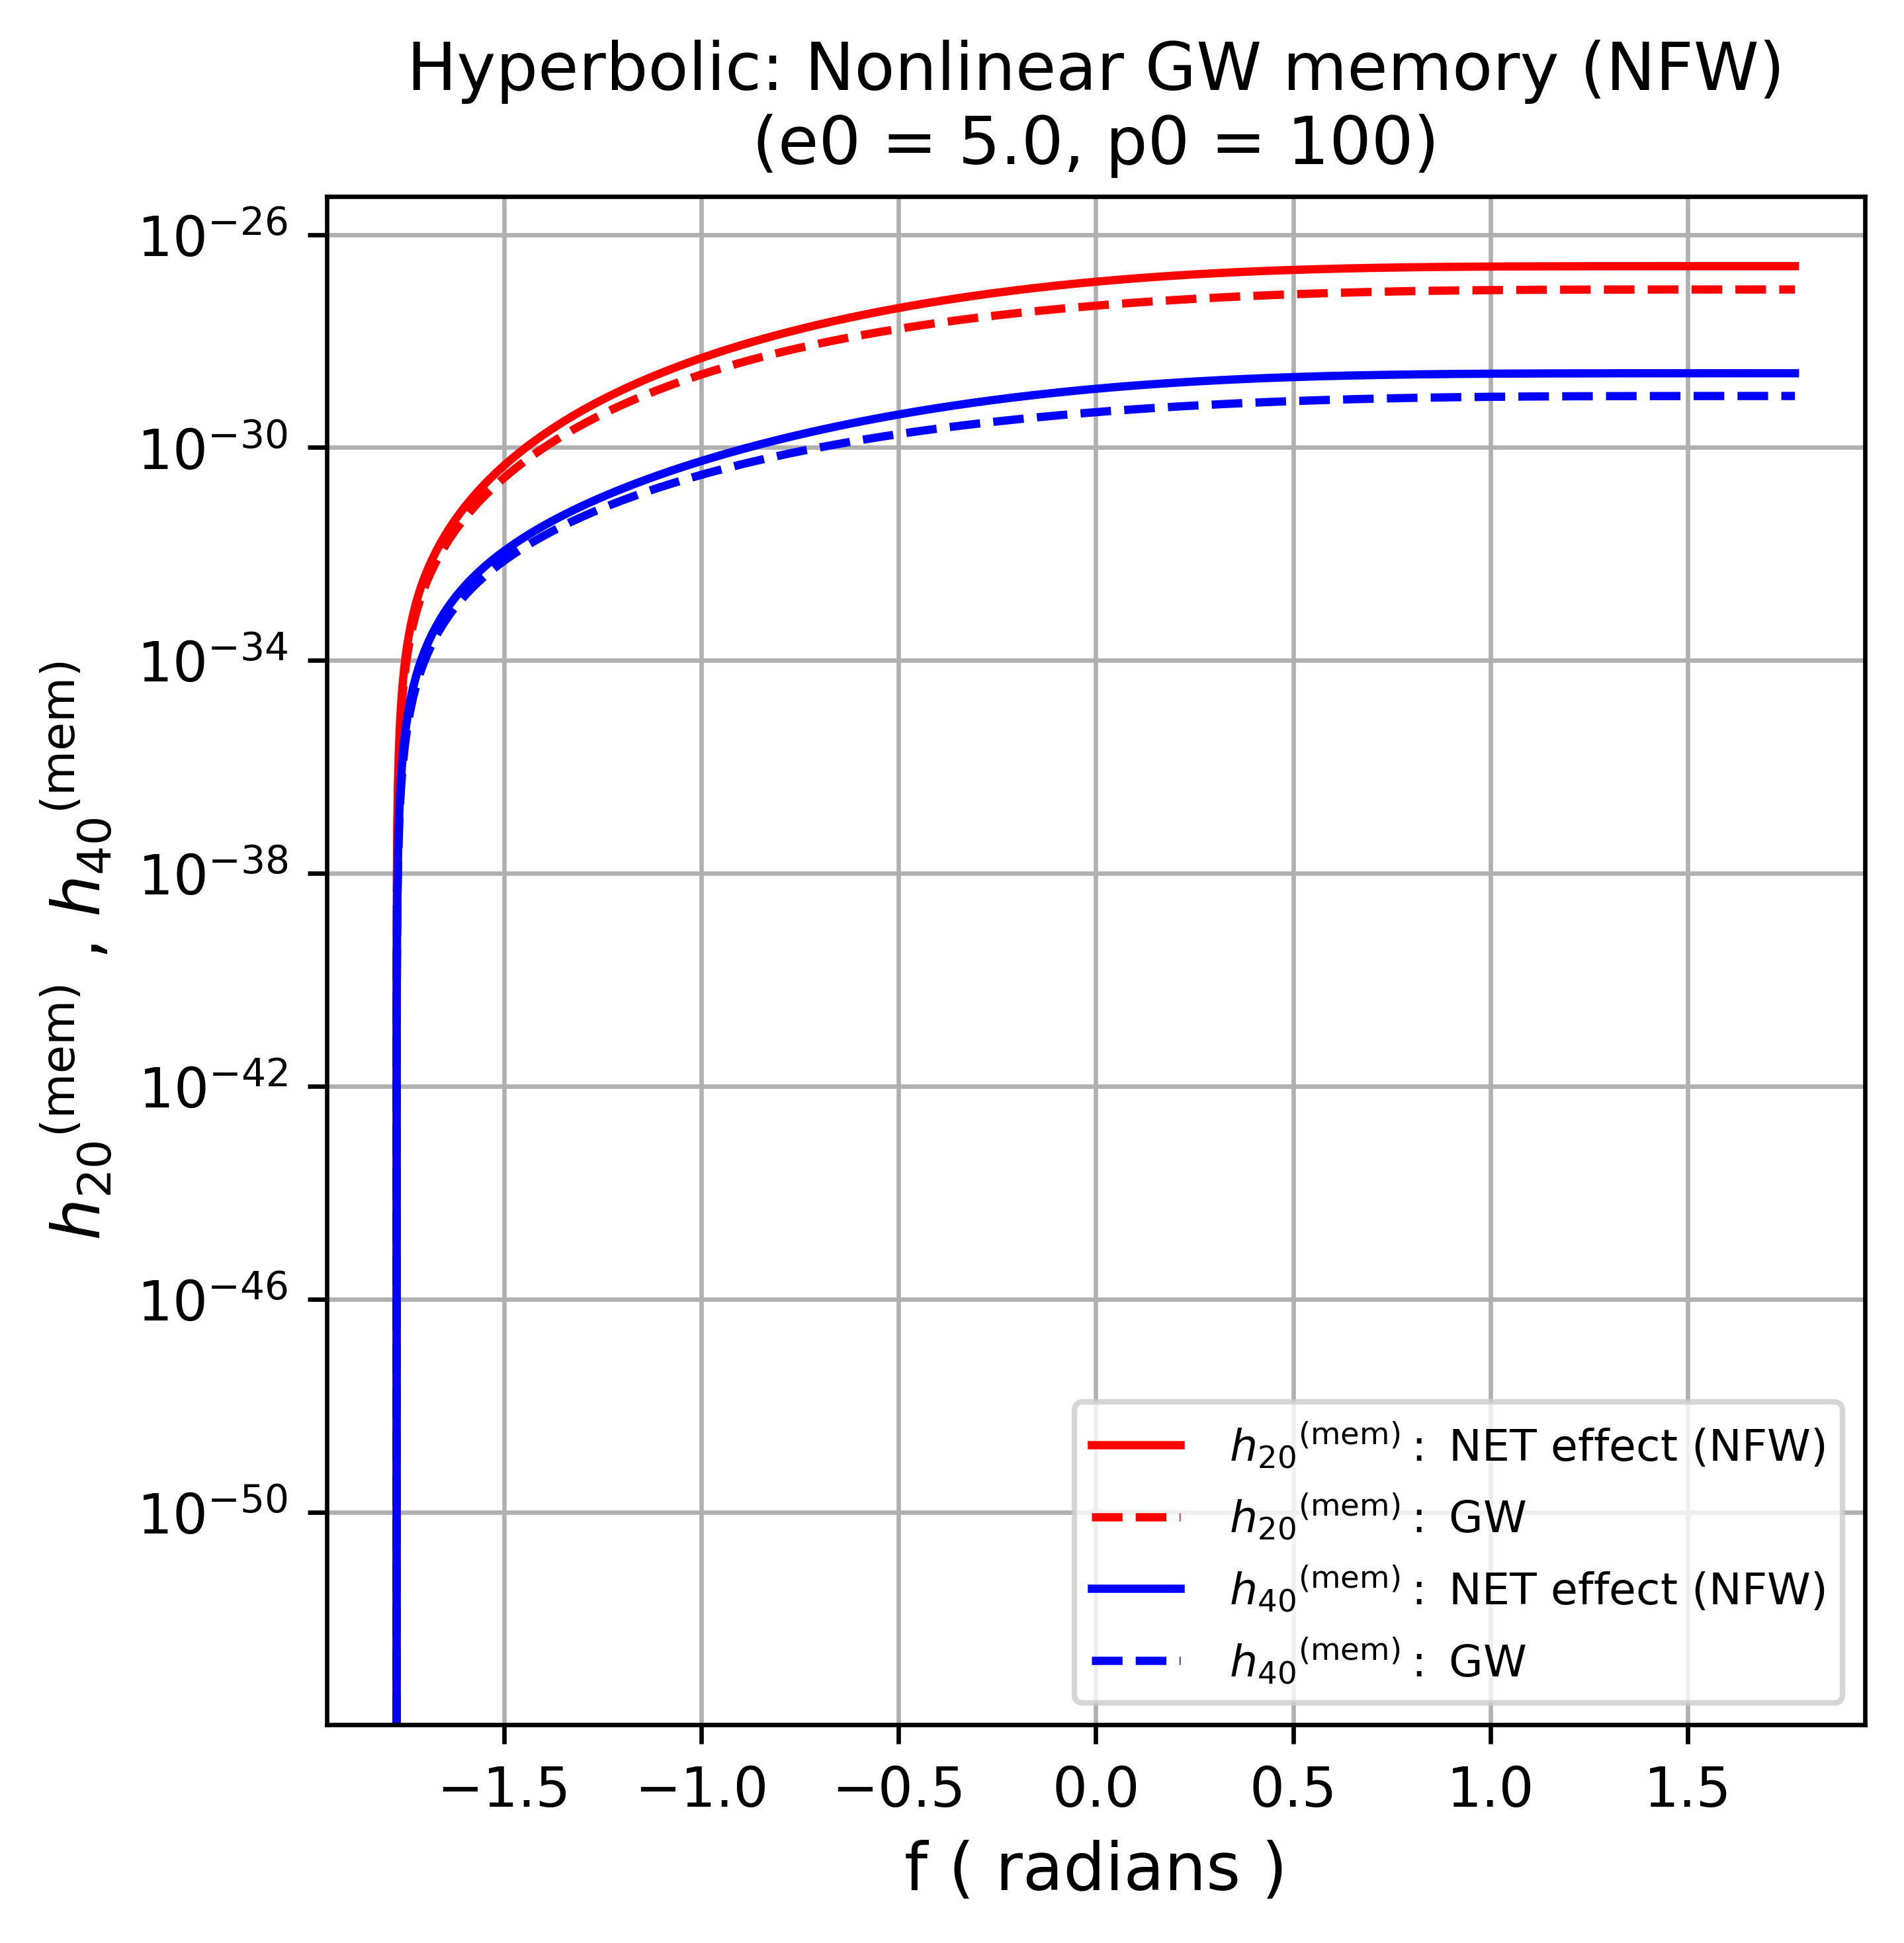

In [19]:
# Plotting
plt.figure(figsize=(5,5))
plt.title('Hyperbolic: Nonlinear GW memory (NFW)' + "\n" + f'(e0 = {e_i}, p0 = {p_i})')

plt.plot( f_net, h20_mem_NET, label = r' ${h_{20}}^{\text{(mem)}}:$' +' NET effect (NFW)', linestyle='-', color='red' )
plt.plot( fgw, h20_mem_gw, label= r' ${h_{20}}^{\text{(mem)}}: $' + ' GW', linestyle='--', color='red')

plt.plot( f_net, h40_mem_NET, label = r' ${h_{40}}^{\text{(mem)}}:$' + ' NET effect (NFW)', linestyle='-', color='blue' )
plt.plot( fgw, h40_mem_gw, label= r' ${h_{40}}^{\text{(mem)}}:$' + ' GW', linestyle='--', color='blue')

plt.xlabel('f ( radians )')
plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
plt.yscale('log')
plt.legend(loc='lower right')
plt.grid(True)

# Save as PDF
plt.savefig("hyperbolic_NFW_plot_1.pdf", format="pdf", bbox_inches="tight")

plt.show()

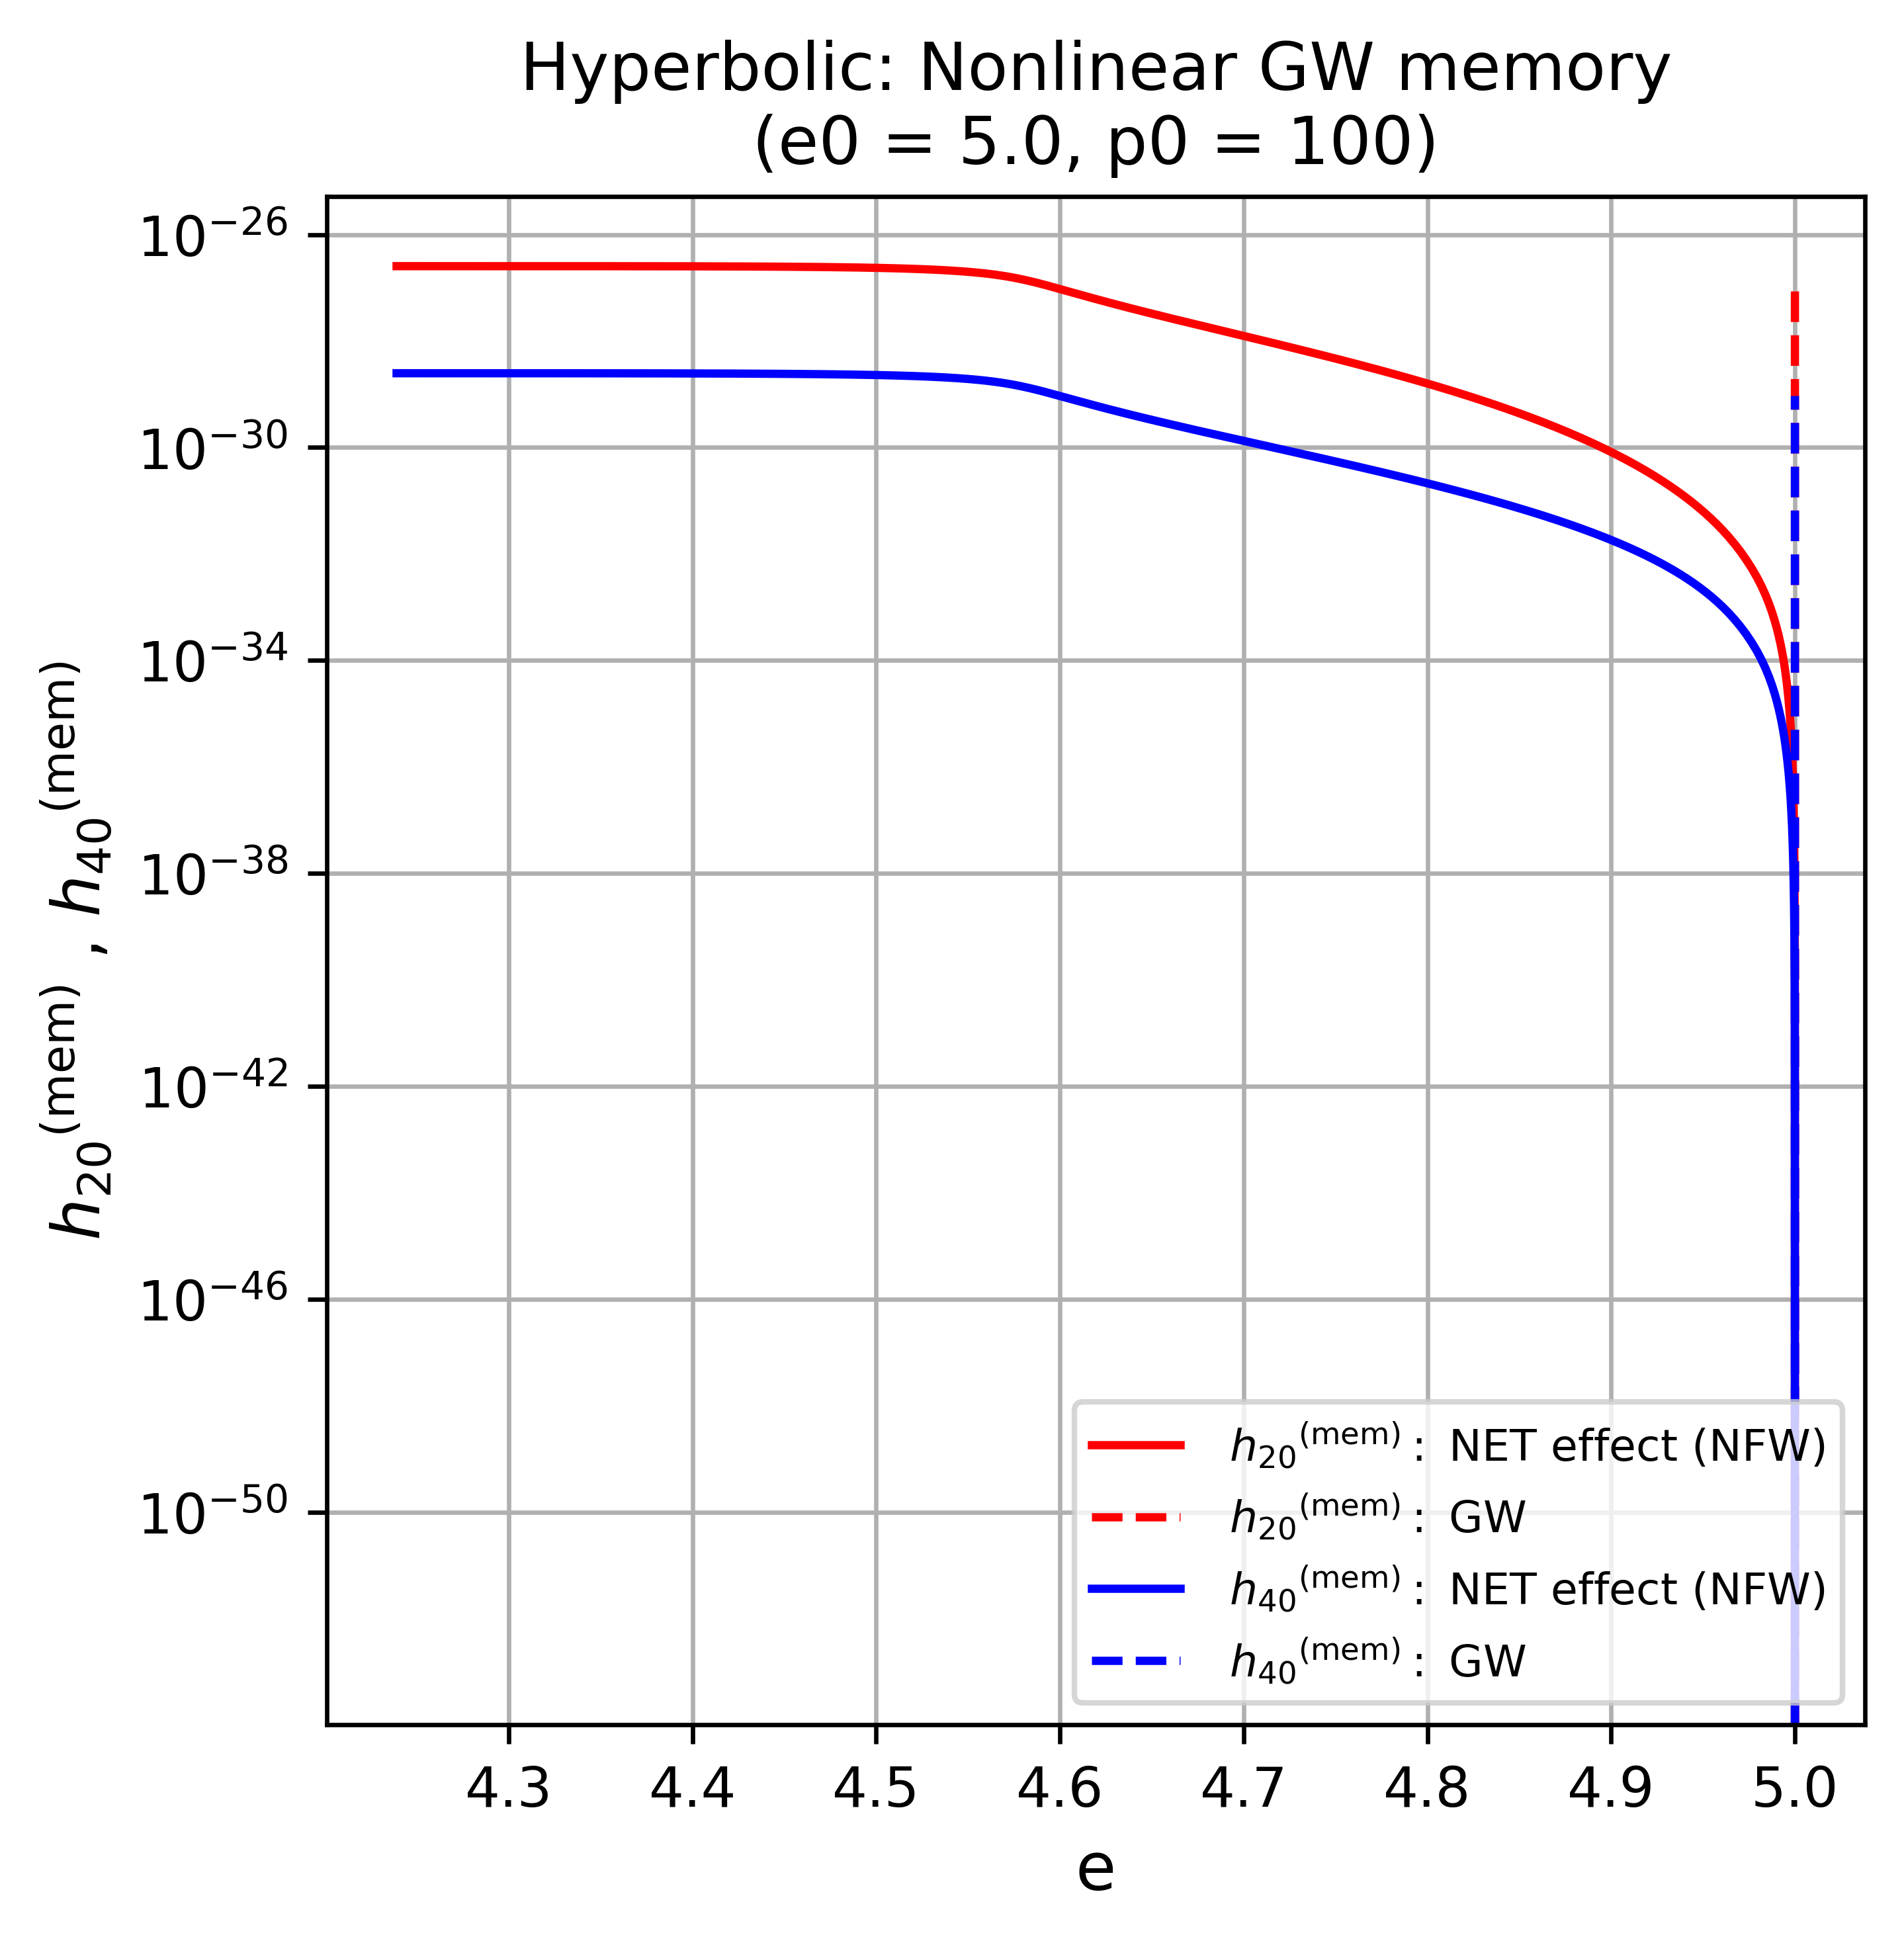

In [20]:
# Plotting
plt.figure(figsize=(5,5))
plt.title('Hyperbolic: Nonlinear GW memory' + "\n" + f'(e0 = {e_i}, p0 = {p_i})')

plt.plot( y_net[0,:], h20_mem_NET, label = r' ${h_{20}}^{\text{(mem)}}:$' +' NET effect (NFW)', linestyle='-', color='red' )
plt.plot( ygw[0,:], h20_mem_gw, label= r' ${h_{20}}^{\text{(mem)}}: $' + ' GW', linestyle='--', color='red')

plt.plot( y_net[0,:], h40_mem_NET, label = r' ${h_{40}}^{\text{(mem)}}:$' + ' NET effect (NFW)', linestyle='-', color='blue' )
plt.plot( ygw[0,:], h40_mem_gw, label= r' ${h_{40}}^{\text{(mem)}}:$' + ' GW', linestyle='--', color='blue')

plt.xlabel('e')
plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
plt.yscale('log')
plt.legend(loc='lower right')
plt.grid(True)

# Save as PDF
plt.savefig("hyperbolic_NFW_plot_2.pdf", format="pdf", bbox_inches="tight")

plt.show()

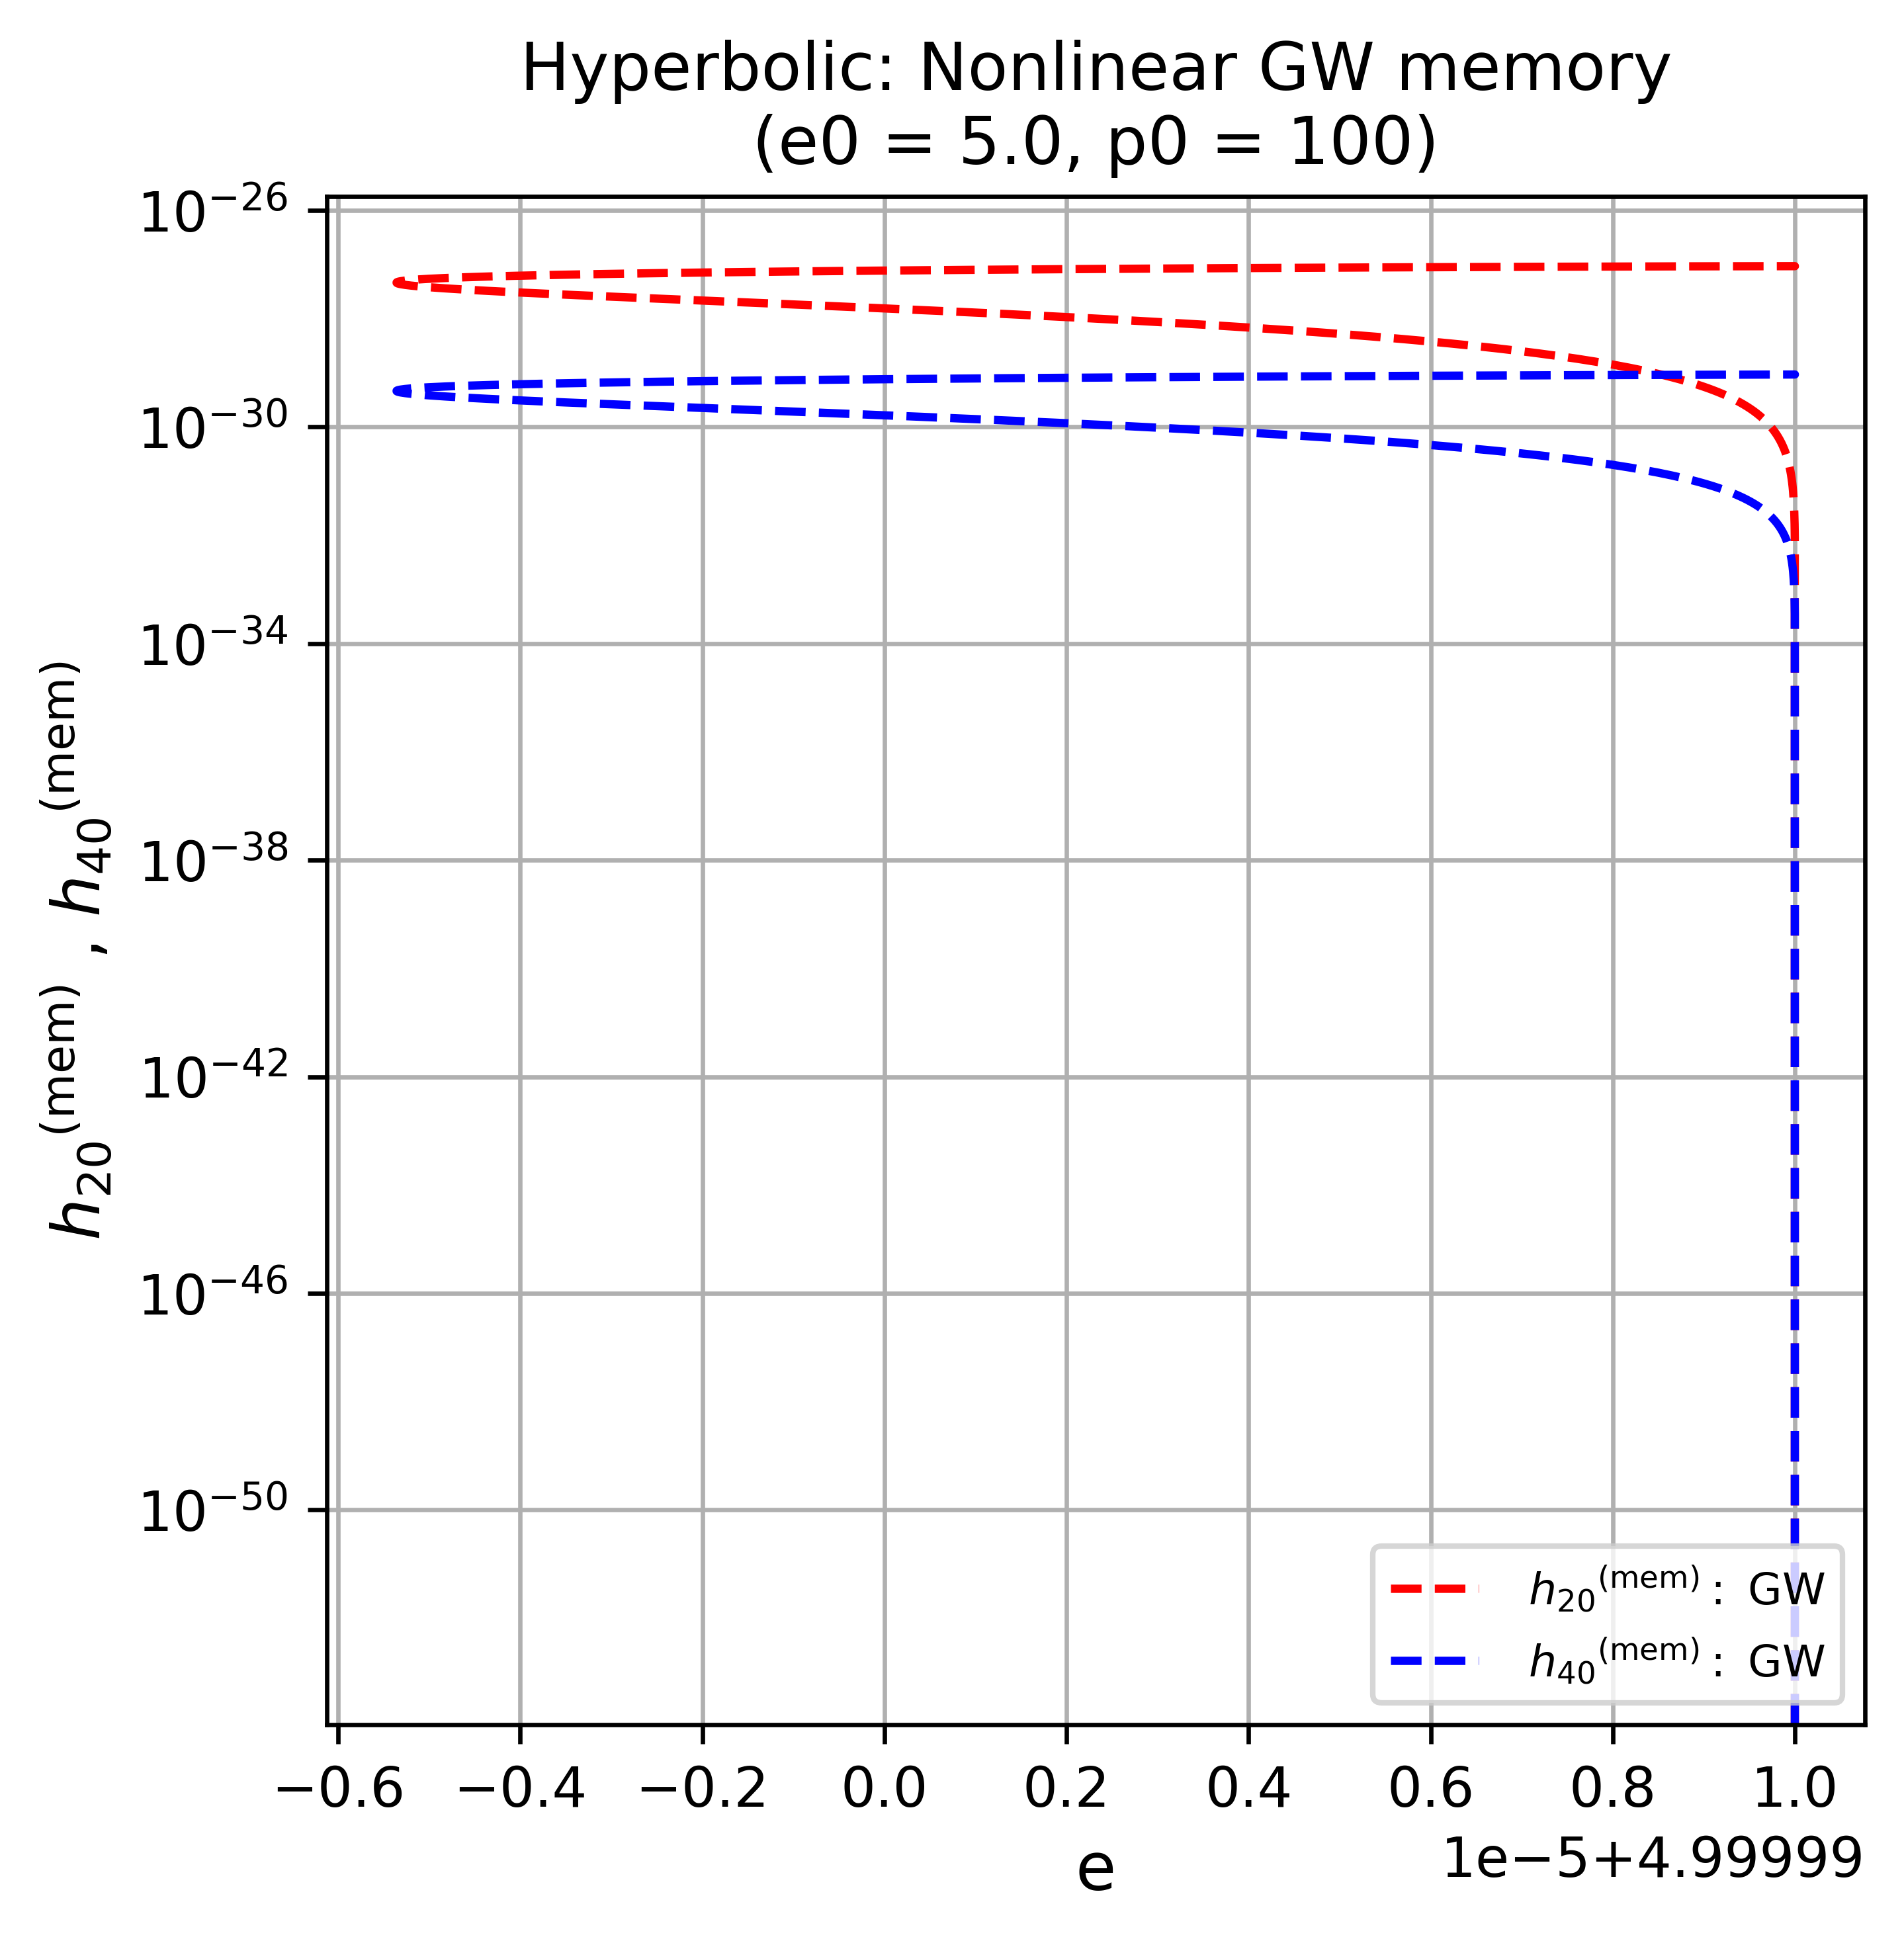

In [21]:
# Plotting
plt.figure(figsize=(5,5))
plt.title('Hyperbolic: Nonlinear GW memory' + "\n" + f'(e0 = {e_i}, p0 = {p_i})')

plt.plot( ygw[0,:], h20_mem_gw, label= r' ${h_{20}}^{\text{(mem)}}: $' + ' GW', linestyle='--', color='red')
plt.plot( ygw[0,:], h40_mem_gw, label= r' ${h_{40}}^{\text{(mem)}}:$' + ' GW', linestyle='--', color='blue')

plt.xlabel('e')
plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
plt.yscale('log')
plt.legend(loc='lower right')
plt.grid(True)

# Save as PDF
plt.savefig("hyperbolic_NFW_plot_3.pdf", format="pdf", bbox_inches="tight") 

plt.show()

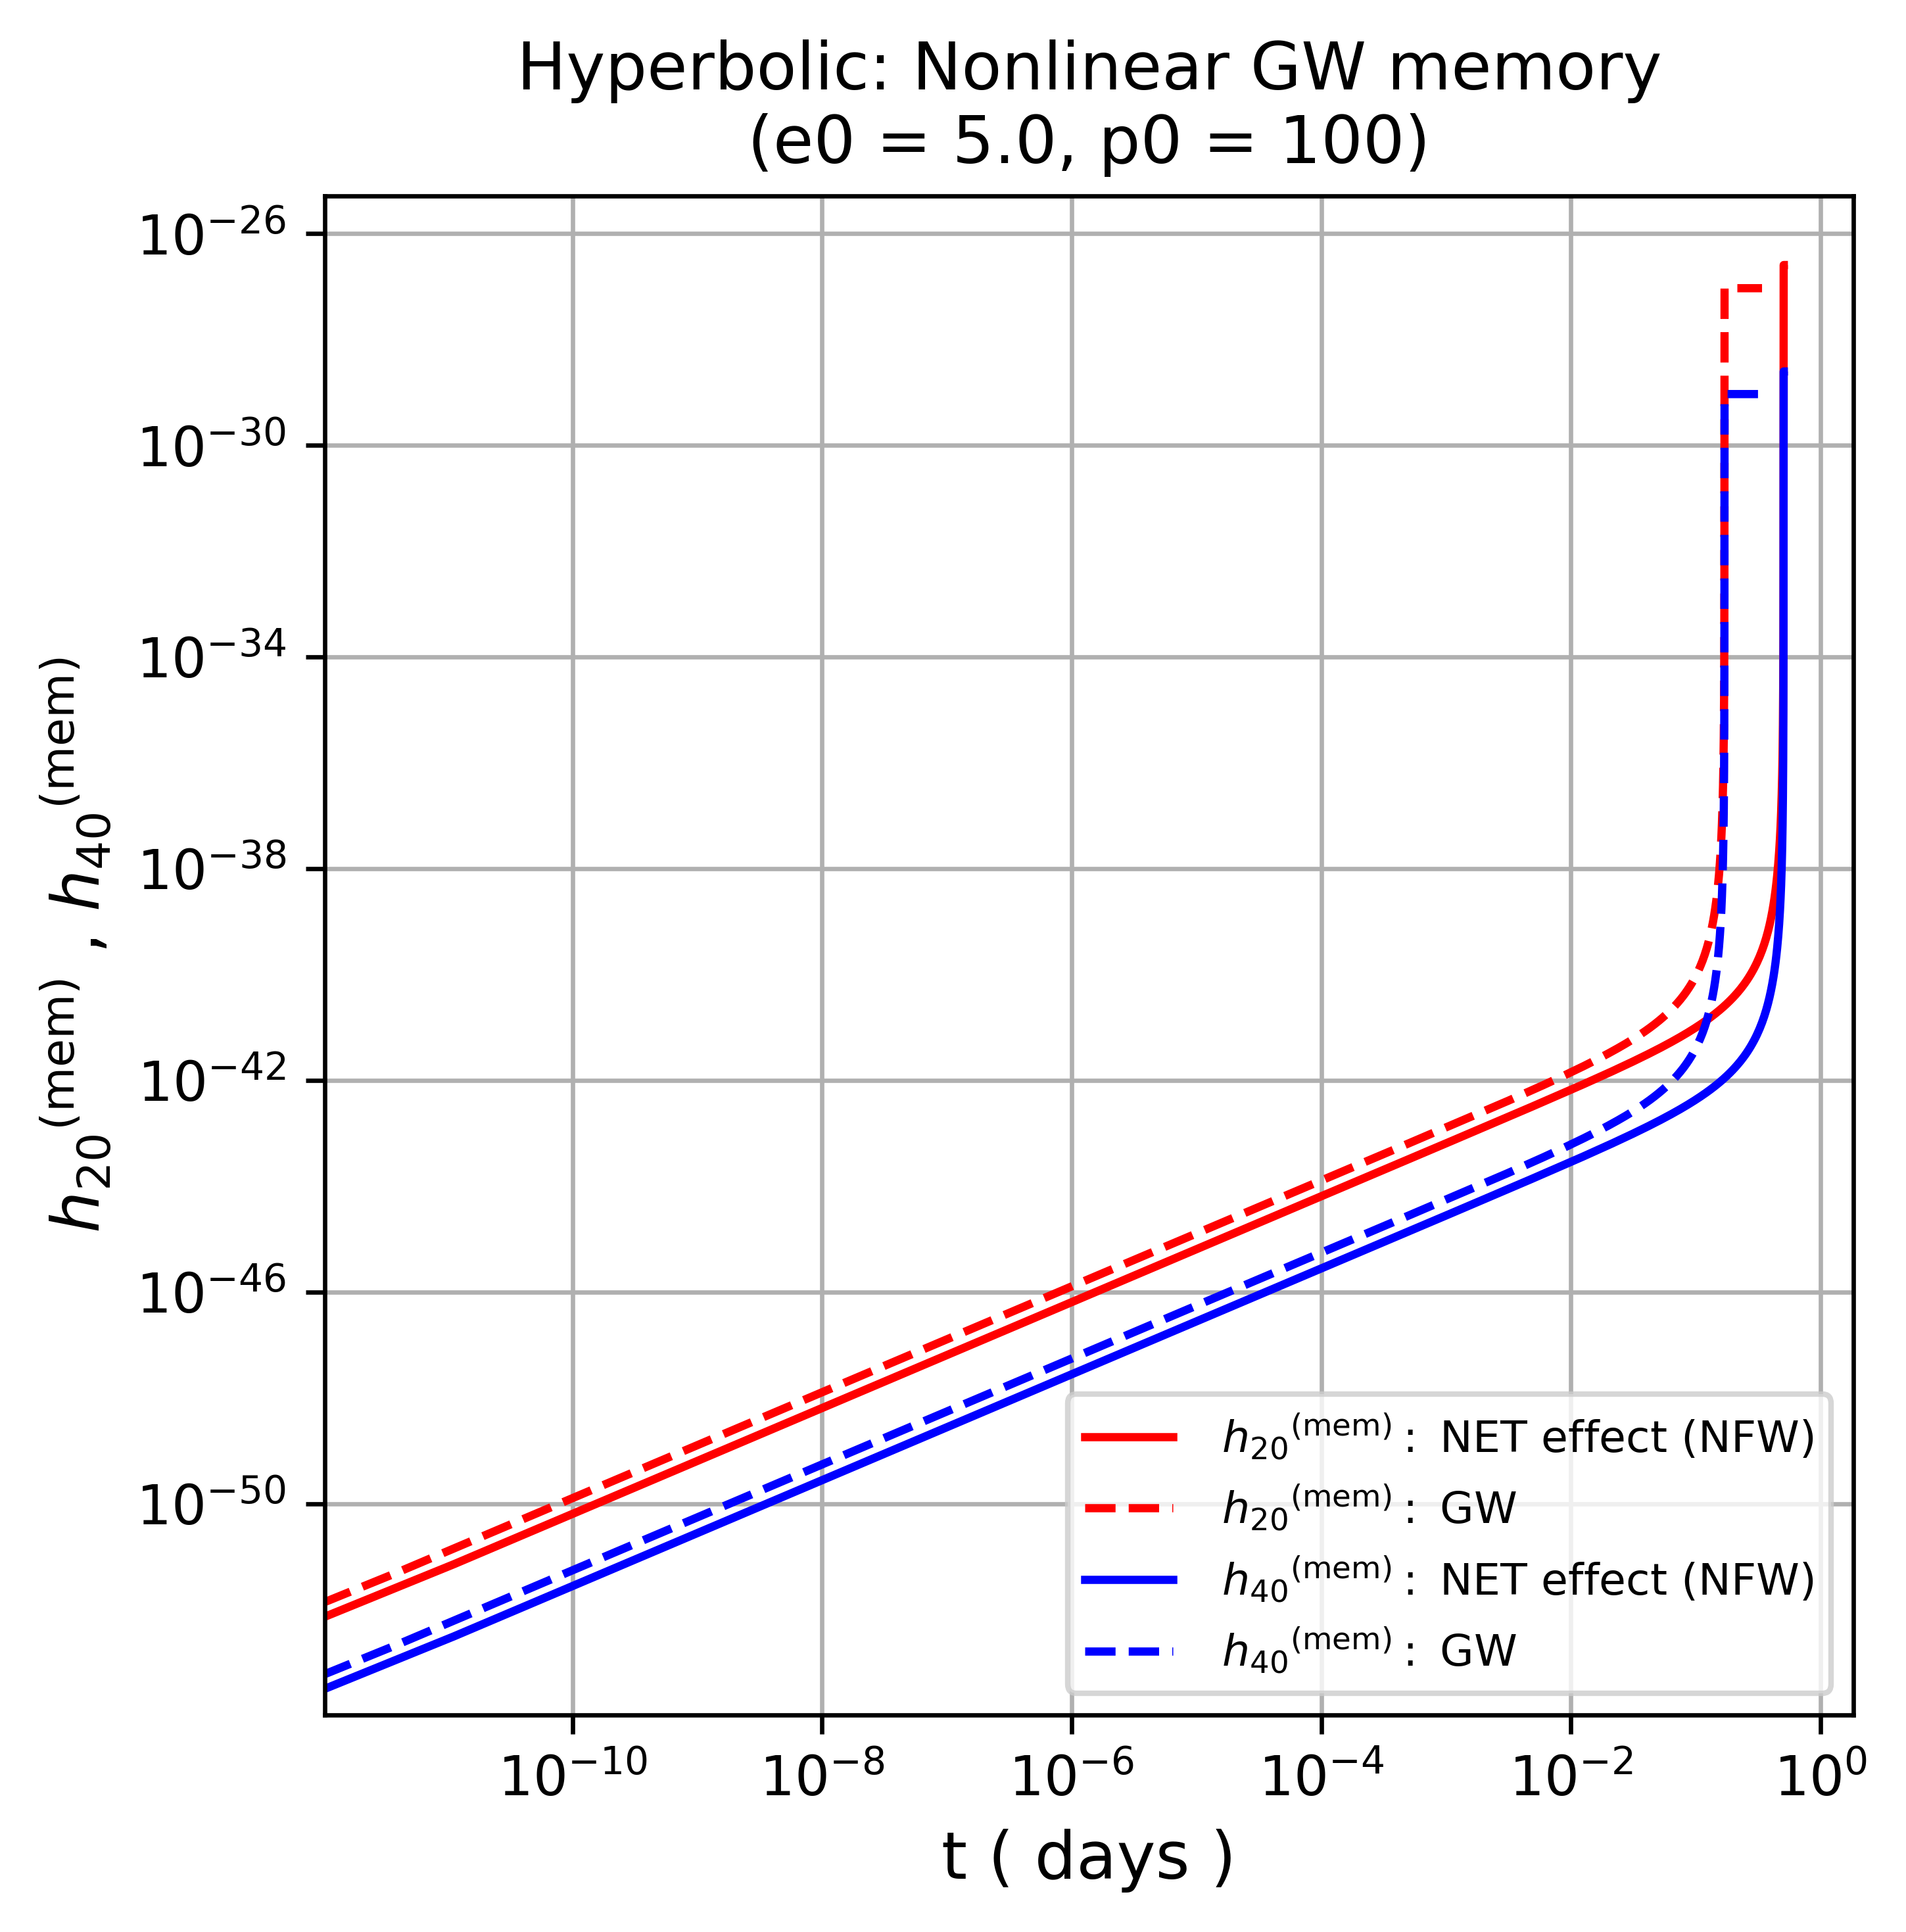

In [22]:
t_day = 24*60*60
# Plotting
plt.figure(figsize=(5,5))
plt.title('Hyperbolic: Nonlinear GW memory' + "\n" + f'(e0 = {e_i}, p0 = {p_i})')

plt.plot( y_net[3,:]*t0/t_day, h20_mem_NET, label = r' ${h_{20}}^{\text{(mem)}}:$' +' NET effect (NFW)', linestyle='-', color='red' )
plt.plot( ygw[3,:]*t0/t_day, h20_mem_gw, label= r' ${h_{20}}^{\text{(mem)}}: $' + ' GW', linestyle='--', color='red')

plt.plot( y_net[3,:]*t0/t_day, h40_mem_NET, label = r' ${h_{40}}^{\text{(mem)}}:$' + ' NET effect (NFW)', linestyle='-', color='blue' )
plt.plot( ygw[3,:]*t0/t_day, h40_mem_gw, label= r' ${h_{40}}^{\text{(mem)}}:$' + ' GW', linestyle='--', color='blue')

plt.xlabel('t ( days )')
plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
plt.grid(True)

# Save as PDF
plt.savefig("hyperbolic_NFW_plot_4.pdf", format="pdf", bbox_inches="tight")

plt.show()

#### Overall Nonlinear GW memory jump

In [23]:
from scipy.integrate import simpson

# Calculating Overall Nonlinear memory jump for  hl0 (l = 2, 4) modes
def hyperbolic_calculate_overall_nonlinear_memory_jump_NFW(e, p_i, R, val, combination):
    # Staring time
    t_i = 0.0
    
    h20_jump = []
    h40_jump = []
    
    # Calculate nonlinear memory jump for different initial eccentricity
    for i in range(len(e)):
        # Initial value of omega ( angle of closest approach ) (in radians, related to initial eccentricity in hyperbolic case)
        omega_i = round(np.arccos(-1/e[i]),2) 
        
        # ------------------- Orbital evolution -----------------------------------------------------
        if combination==0:
            # GW backrxn only ( For FAVATA result, val=2.5 )    
            sol_without_DM = hyperbolic_orbit_evolution_without_DM(e[i], p_i, omega_i, t_i)
            f, y = sol_without_DM.hyperbolic_orbit_evolution_gw_brxn(val)   
        else:
            # NET : DF + Accretion + DM gravity + GW backrxn
            sol_with_DM = hyperbolic_orbit_evolution_with_NFW_DM(e[i], p_i, omega_i, t_i)
            f, y = sol_with_DM.hyperbolic_orbit_evolution_NFW_DM_effect_gw_brxn(val)  

        num = len(f)

        # ----------------- Nonlinear memory calculation --------------------------------------------
        h20dot_mem = dh20dt_mem(y, f, R, combination, val)
        h40dot_mem = dh40dt_mem(y, f, R, combination, val)

        dh20df_mem = []
        dh40df_mem = []

        for j in range(num):
            if combination==0:
                # GW backrxn only ( For FAVATA result, val=2.5 ) 
                dedf, dpdf, domegadf, dtdf = hyperbolic_osculating_eqn_gw_brxn(f[j], y[:,j], val)
                dh20df_mem.append( h20dot_mem[j] * dtdf ) 
                dh40df_mem.append( h40dot_mem[j] * dtdf ) 
            else:
                # NET : DF + Accretion + DM gravity + GW backrxn
                dedf, dpdf, domegadf, dtdf = np.add.reduce([hyperbolic_osculating_eqn_gw_brxn(f[j],y[:,j],val),
                                               hyperbolic_osculating_eqn_DF_accretion_NFW(f[j], y[:,j]),
                                               hyperbolic_osculating_eqn_DM_gravity_NFW(f[j], y[:,j])])
                dh20df_mem.append( h20dot_mem[j] * dtdf ) 
                dh40df_mem.append( h40dot_mem[j] * dtdf ) 

        h20_jump.append(simpson(dh20df_mem, f))
        h40_jump.append(simpson(dh40df_mem, f))

    return h20_jump, h40_jump

In [24]:
e = np.linspace(1, 10, 100)  # initial eccentricity array

# Overall nonlinear memory jump for different initial eccentricity

# Only GW backreaction ( FAVATA result )
h20jump_without_DM, h40jump_without_DM = hyperbolic_calculate_overall_nonlinear_memory_jump_NFW(e, p_i, R, val=2.5, combination=0)

# NET : DM gravity + DF + Accretion + GW brxn
h20jump_with_DM, h40jump_with_DM = hyperbolic_calculate_overall_nonlinear_memory_jump_NFW(e, p_i, R, val=0, combination=3)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached th

In [25]:
# Save array : WITH DM 
np.save("hyp_h20jump_with_DM_NFW.npy", h20jump_with_DM)
np.save("hyp_h40jump_with_DM_NFW.npy", h40jump_with_DM)

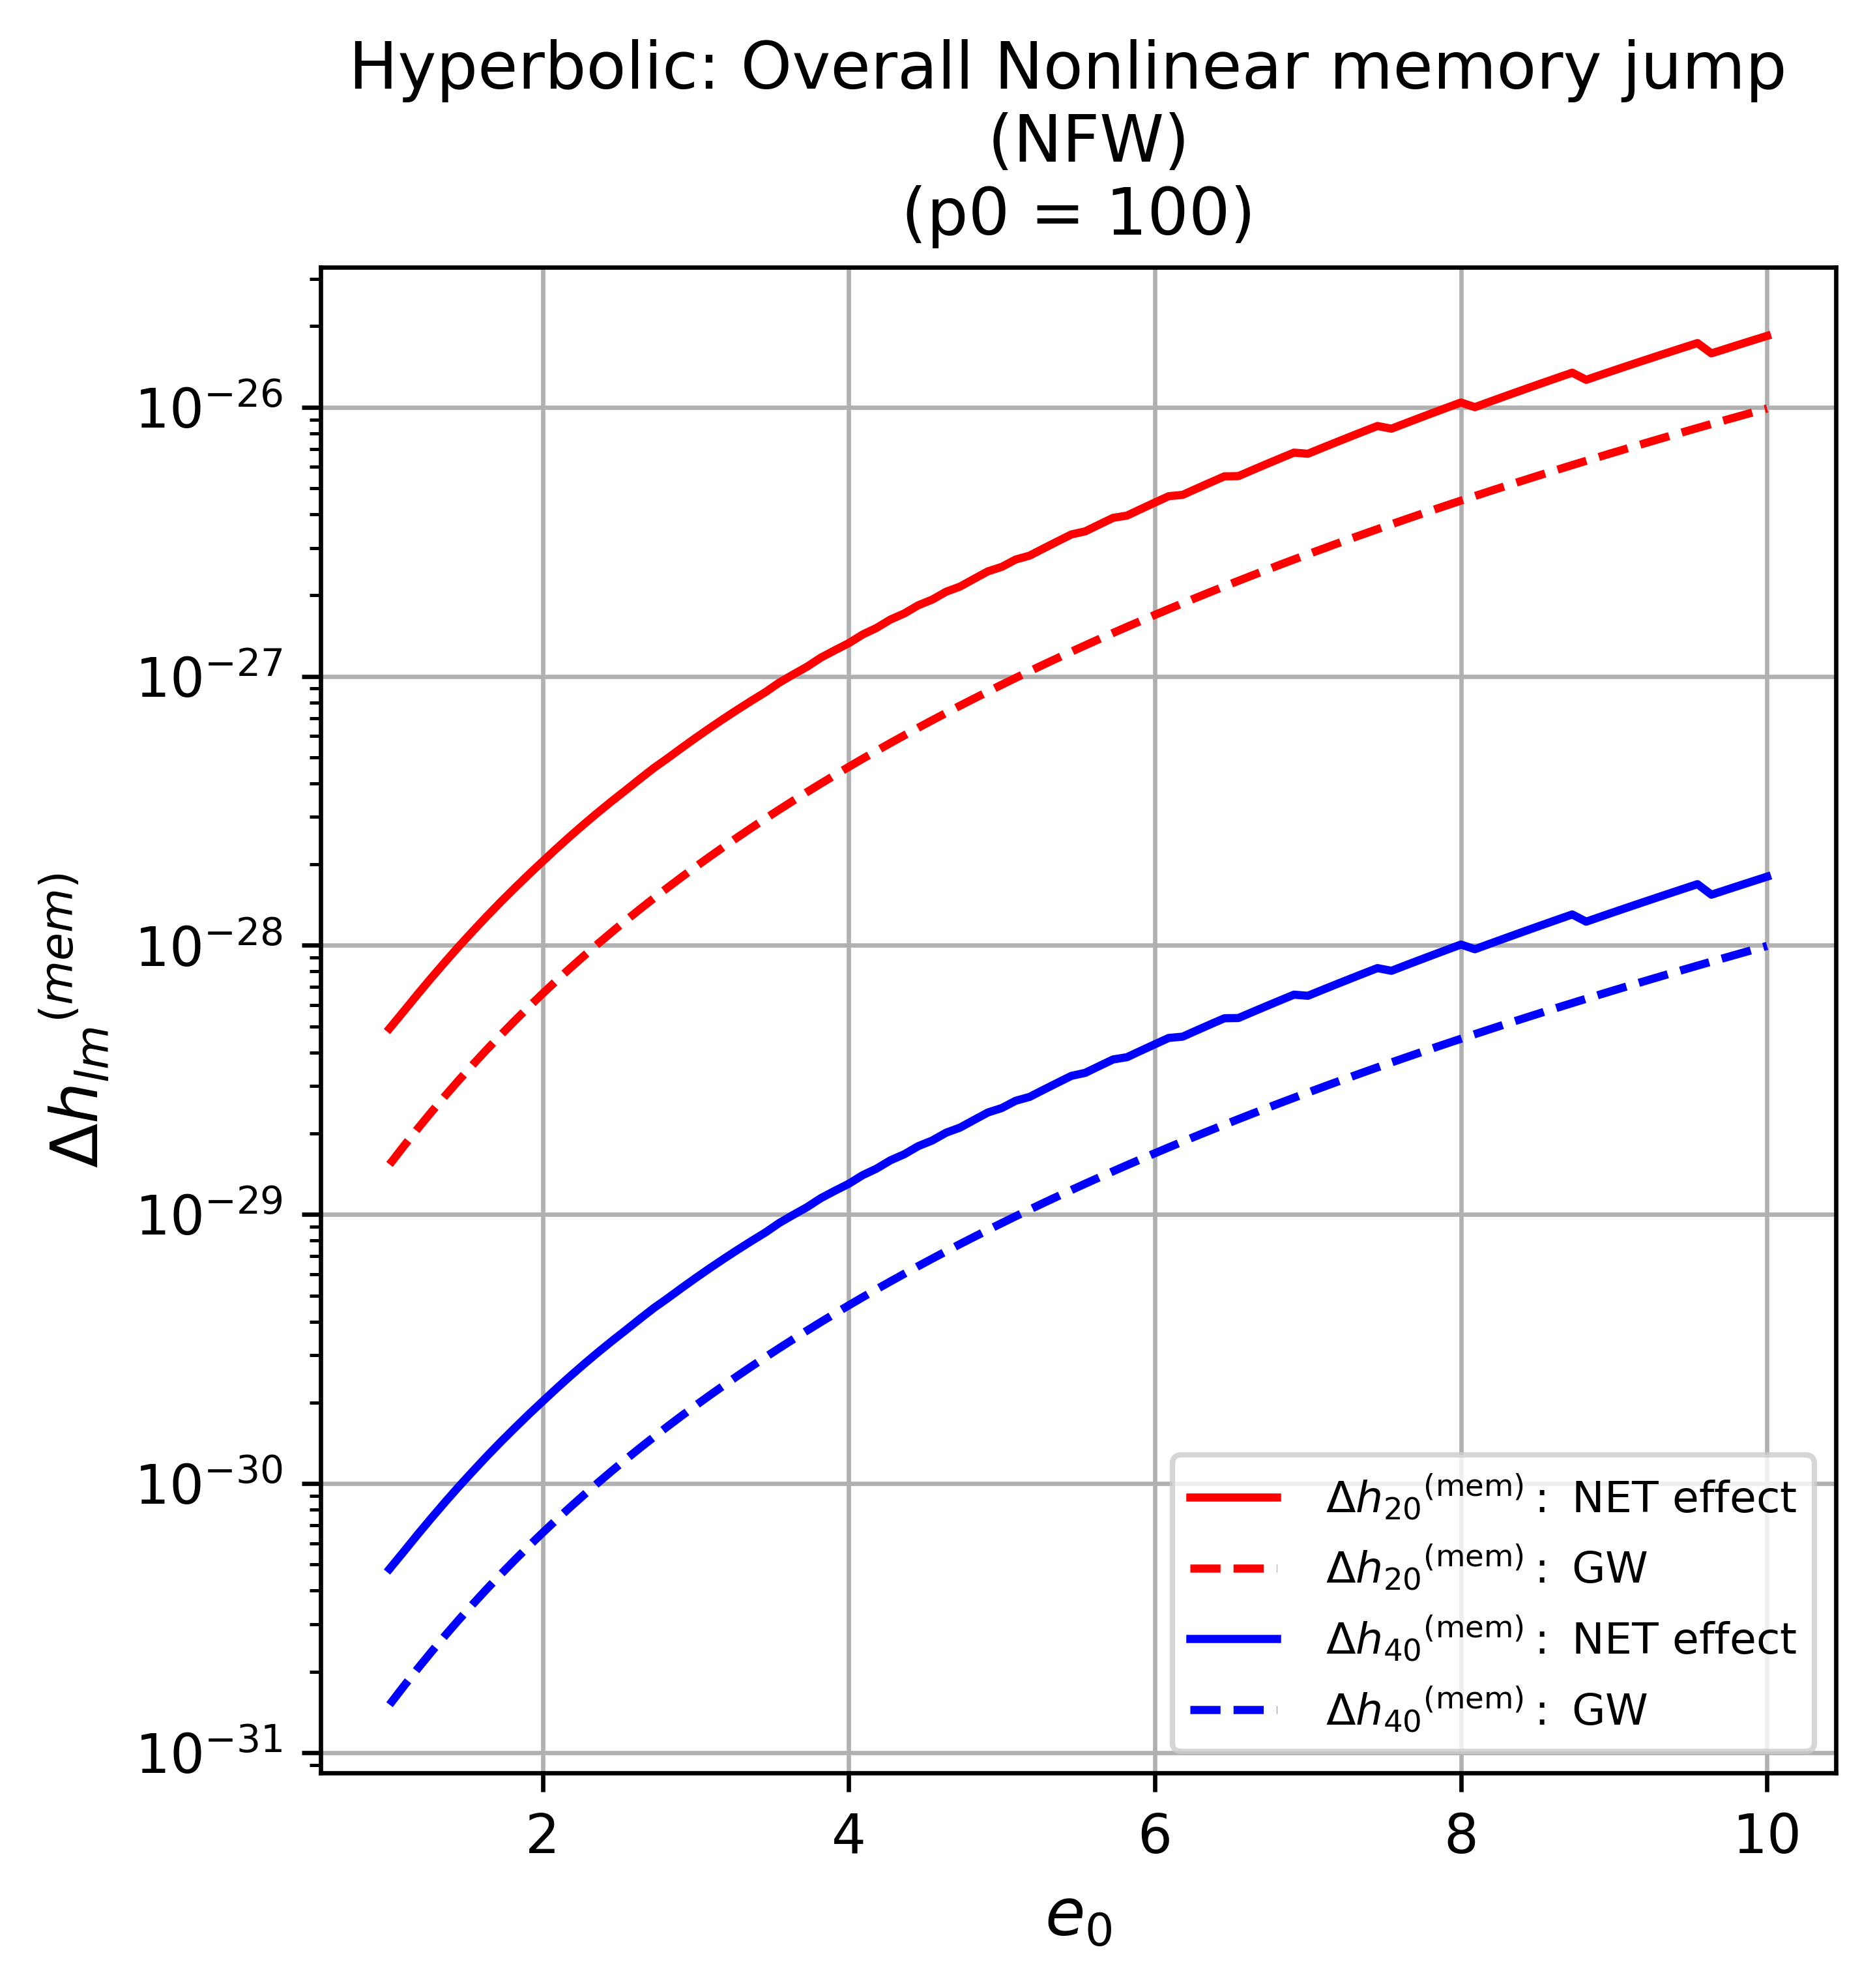

In [26]:
# Plotting
plt.figure(figsize=(5,5))
plt.title('Hyperbolic: Overall Nonlinear memory jump \n (NFW)' + "\n" + f'(p0 = {p_i})')

plt.plot( e, h20jump_with_DM, label = r' $\Delta {h_{20}}^{\text{(mem)}}:$' +' NET effect', linestyle='-', color='red' )
plt.plot( e, h20jump_without_DM, label= r' $\Delta {h_{20}}^{\text{(mem)}}: $' + ' GW', linestyle='--', color='red')

plt.plot( e, h40jump_with_DM, label = r' $\Delta {h_{40}}^{\text{(mem)}}:$' + ' NET effect', linestyle='-', color='blue' )
plt.plot( e, h40jump_without_DM, label= r' $\Delta {h_{40}}^{\text{(mem)}}:$' + ' GW', linestyle='--', color='blue')

plt.xlabel(r'$e_0$')
plt.ylabel(r'$\Delta {h_{lm}}^{(mem)}$')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
plt.grid(True)

# Save as PDF
plt.savefig("hyperbolic_NFW_plot_5.pdf", format="pdf", bbox_inches="tight")

plt.show()

#### Hyperbolic : Nonlinear memory for three-different initial eccentricities ( e )

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


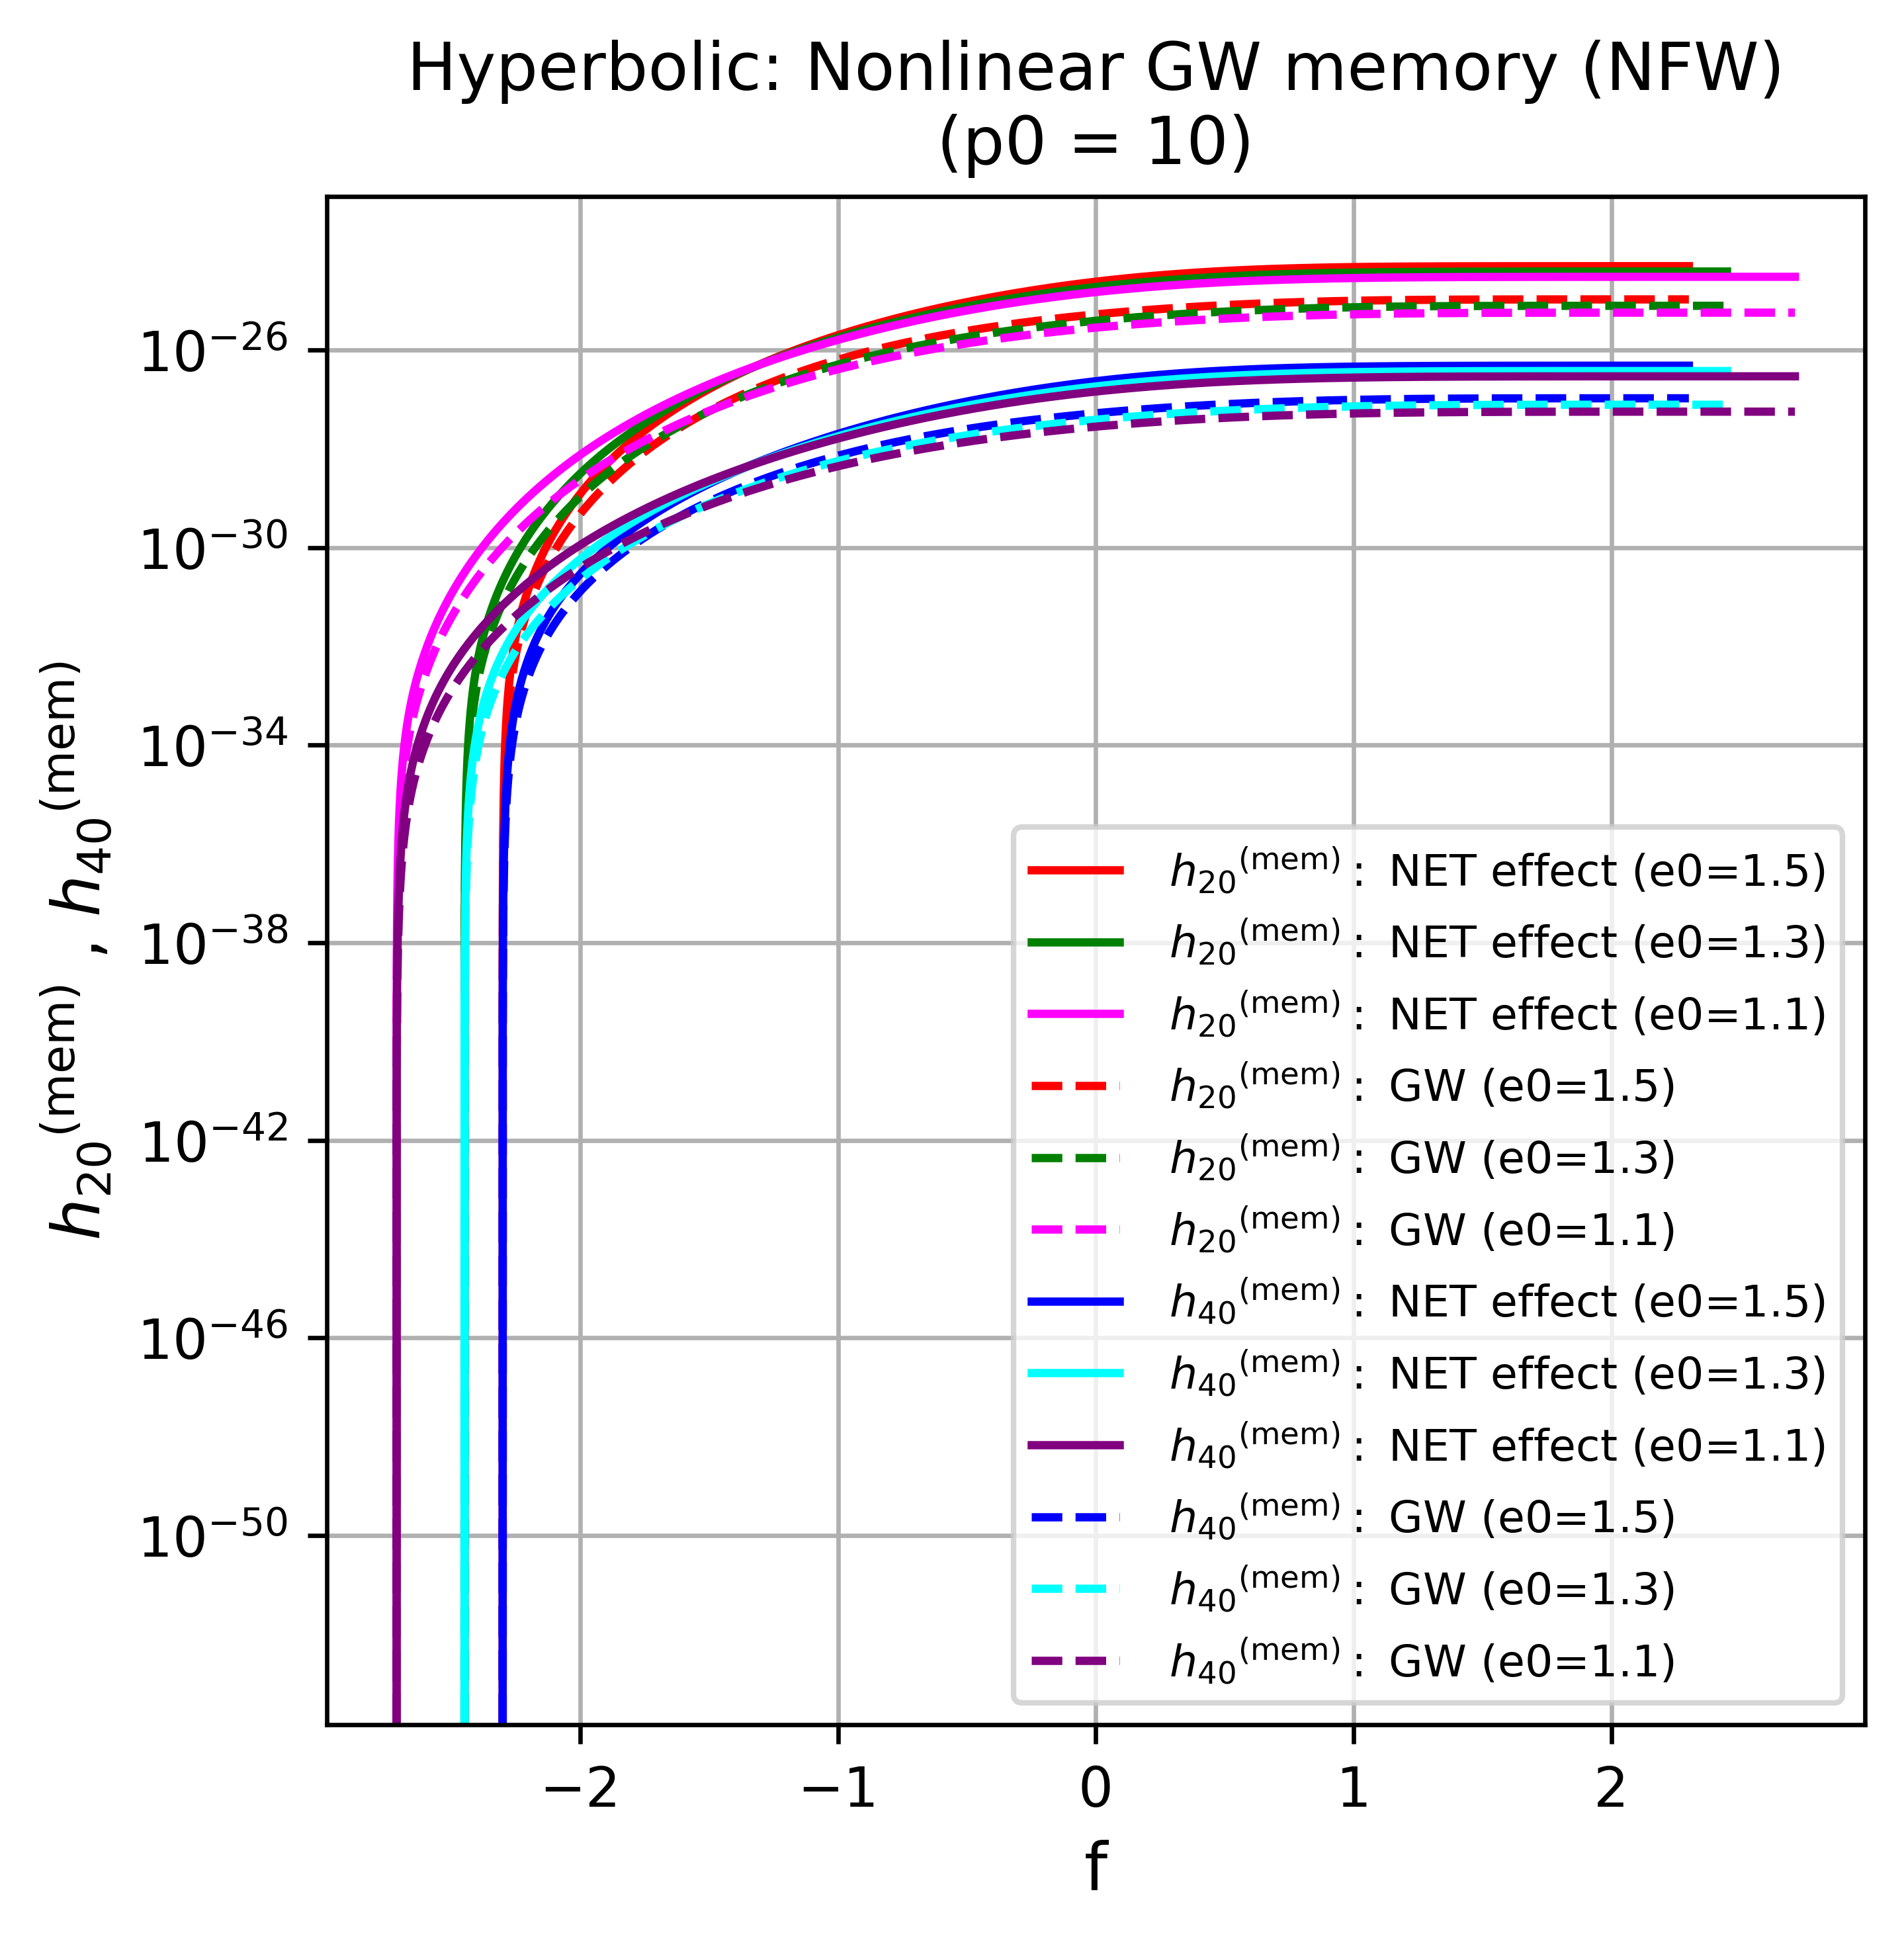

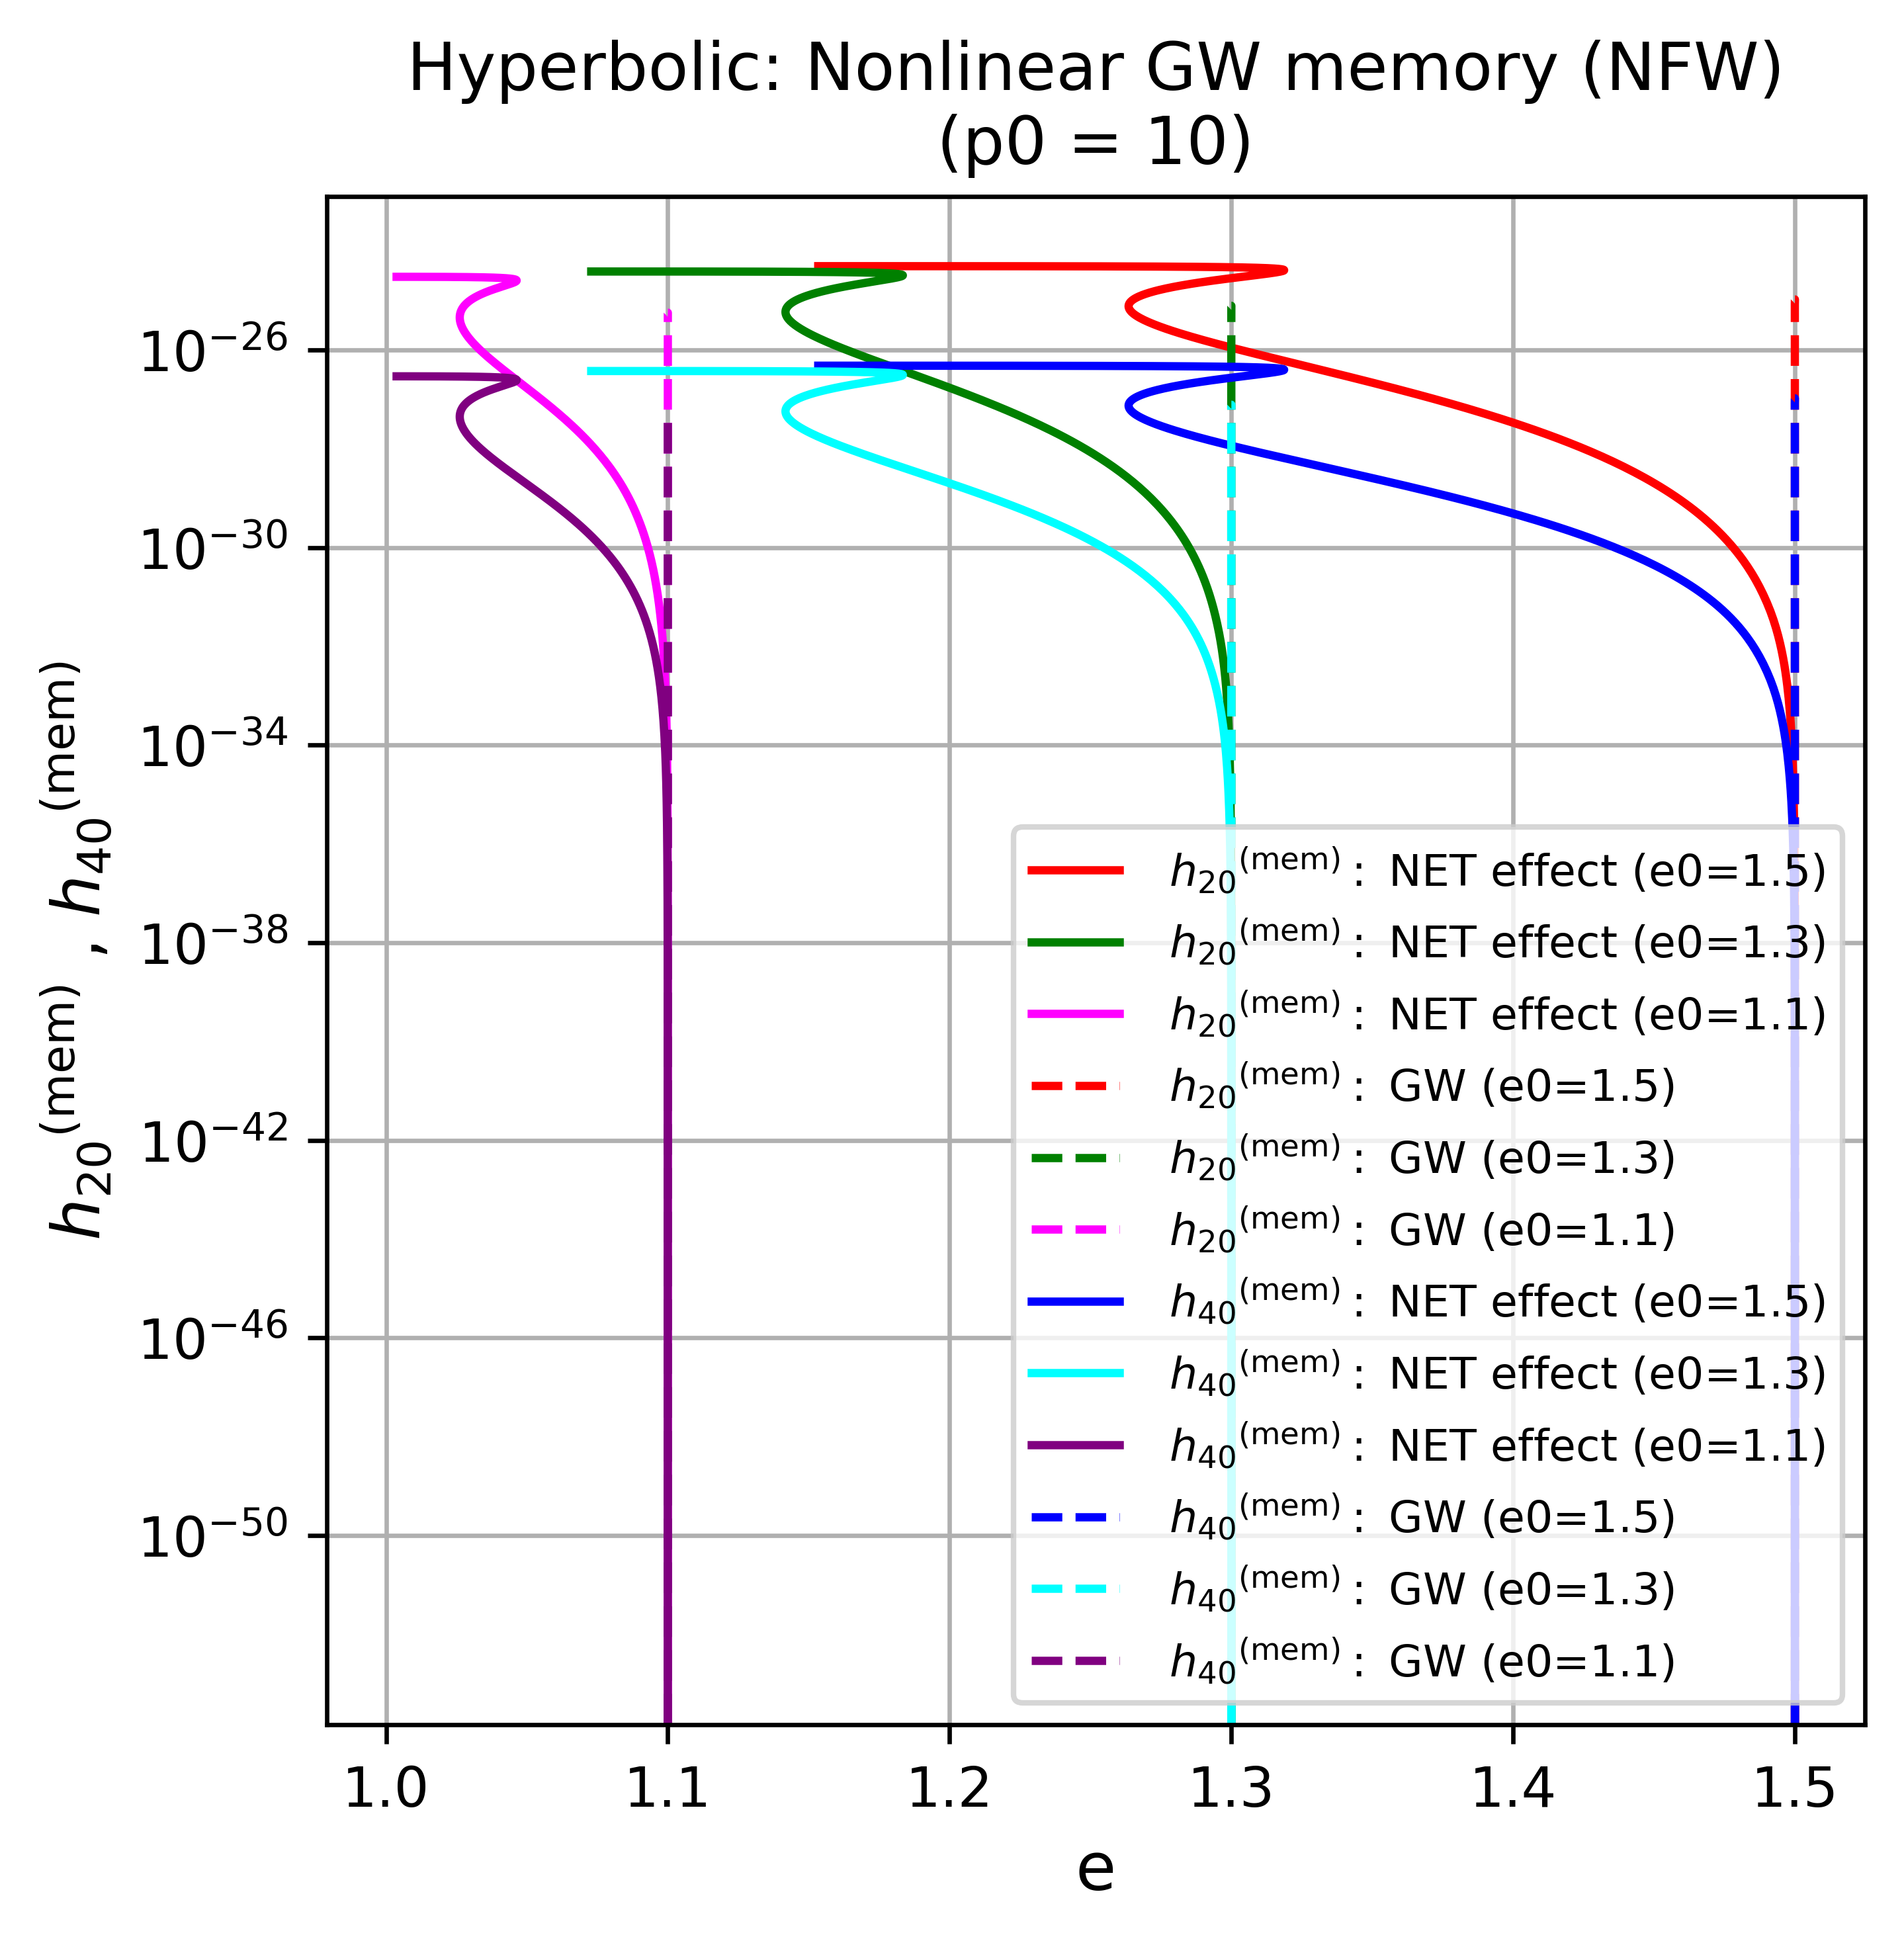

In [27]:
def hyperbolic_nonlinear_memo_diff_init_eccentricities(e_initials, p_0, t_0, R):
    # initial eccentricities
    e0_1, omega0_1 = e_initials[0], round(np.arccos(-1/e_initials[0]),2)
    e0_2, omega0_2 = e_initials[1], round(np.arccos(-1/e_initials[1]),2)
    e0_3, omega0_3 = e_initials[2], round(np.arccos(-1/e_initials[2]),2) 

    # Calculating Nonlinear GW memory for given initial orbital parameters
    hyperbolic_nonlinear_memory1 = hyperbolic_calculate_nonlinear_memory_NFW(e0_1, p_0, omega0_1, t_0, R)
    hyperbolic_nonlinear_memory2 = hyperbolic_calculate_nonlinear_memory_NFW(e0_2, p_0, omega0_2, t_0, R)
    hyperbolic_nonlinear_memory3 = hyperbolic_calculate_nonlinear_memory_NFW(e0_3, p_0, omega0_3, t_0, R)
    
    # Only GW backreaction
    fgw1, ygw1, h20_mem_gw1, h40_mem_gw1 = hyperbolic_nonlinear_memory1.cal_hl0(val=2.5, combination=0)
    fgw2, ygw2, h20_mem_gw2, h40_mem_gw2 = hyperbolic_nonlinear_memory2.cal_hl0(val=2.5, combination=0)
    fgw3, ygw3, h20_mem_gw3, h40_mem_gw3 = hyperbolic_nonlinear_memory3.cal_hl0(val=2.5, combination=0)
    
    # NET : DM gravity + DF + Accretion + GW brxn
    f_net1, y_net1, h20_mem_NET1, h40_mem_NET1 = hyperbolic_nonlinear_memory1.cal_hl0(val=0, combination=3)
    f_net2, y_net2, h20_mem_NET2, h40_mem_NET2 = hyperbolic_nonlinear_memory2.cal_hl0(val=0, combination=3)
    f_net3, y_net3, h20_mem_NET3, h40_mem_NET3 = hyperbolic_nonlinear_memory3.cal_hl0(val=0, combination=3)

    # Plotting Nonlinear memory VS True anomaly
    plt.figure(figsize=(5,5))
    plt.title('Hyperbolic: Nonlinear GW memory (NFW)' + "\n" + f'(p0 = {p_0})')
    
    plt.plot( f_net1, h20_mem_NET1, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_1})', linestyle='-', color='red' )
    plt.plot( f_net2, h20_mem_NET2, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_2})', linestyle='-', color='green' )
    plt.plot( f_net3, h20_mem_NET3, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_3})', linestyle='-', color='magenta' )
    
    plt.plot( fgw1, h20_mem_gw1, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (e0={e0_1})', linestyle='--', color='red')
    plt.plot( fgw2, h20_mem_gw2, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (e0={e0_2})', linestyle='--', color='green')
    plt.plot( fgw3, h20_mem_gw3, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (e0={e0_3})', linestyle='--', color='magenta')
    
    plt.plot( f_net1, h40_mem_NET1, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_1})', linestyle='-', color='blue' )
    plt.plot( f_net2, h40_mem_NET2, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_2})', linestyle='-', color='cyan' )
    plt.plot( f_net3, h40_mem_NET3, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_3})', linestyle='-', color='purple' )
    
    plt.plot( fgw1, h40_mem_gw1, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (e0={e0_1})', linestyle='--', color='blue')
    plt.plot( fgw2, h40_mem_gw2, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (e0={e0_2})', linestyle='--', color='cyan')
    plt.plot( fgw3, h40_mem_gw3, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (e0={e0_3})', linestyle='--', color='purple')
    
    plt.xlabel('f')
    plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Save as PDF
    plt.savefig("hyperbolic_NFW_plot_6.pdf", format="pdf", bbox_inches="tight")

    plt.show()
        
    # Plotting Nonlinear memory VS eccentricity
    plt.figure(figsize=(5,5))
    plt.title('Hyperbolic: Nonlinear GW memory (NFW)' + "\n" + f'(p0 = {p_0})')
    
    plt.plot( y_net1[0,:], h20_mem_NET1, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_1})', linestyle='-', color='red' )
    plt.plot( y_net2[0,:], h20_mem_NET2, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_2})', linestyle='-', color='green' )
    plt.plot( y_net3[0,:], h20_mem_NET3, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_3})', linestyle='-', color='magenta' )
    
    plt.plot( ygw1[0,:], h20_mem_gw1, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (e0={e0_1})', linestyle='--', color='red')
    plt.plot( ygw2[0,:], h20_mem_gw2, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (e0={e0_2})', linestyle='--', color='green')
    plt.plot( ygw3[0,:], h20_mem_gw3, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (e0={e0_3})', linestyle='--', color='magenta')
    
    plt.plot( y_net1[0,:], h40_mem_NET1, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_1})', linestyle='-', color='blue' )
    plt.plot( y_net2[0,:], h40_mem_NET2, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_2})', linestyle='-', color='cyan' )
    plt.plot( y_net3[0,:], h40_mem_NET3, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (e0={e0_3})', linestyle='-', color='purple' )
    
    plt.plot( ygw1[0,:], h40_mem_gw1, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (e0={e0_1})', linestyle='--', color='blue')
    plt.plot( ygw2[0,:], h40_mem_gw2, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (e0={e0_2})', linestyle='--', color='cyan')
    plt.plot( ygw3[0,:], h40_mem_gw3, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (e0={e0_3})', linestyle='--', color='purple')
    
    plt.xlabel('e')
    plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
    # plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Save as PDF
    plt.savefig("hyperbolic_NFW_plot_7.pdf", format="pdf", bbox_inches="tight") 

    plt.show()

# Initial orbital parameters
e_initials = [1.5, 1.3, 1.1] # initial eccentricities
p0, t0 = 10, 0.0

# Plotting Nonlinear memory for three-different initial eccentricities
hyperbolic_nonlinear_memo_diff_init_eccentricities(e_initials, p0, t0, R)

#### Hyperbolic : Nonlinear memory for three-different initial semi-latus rectum ( p )

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


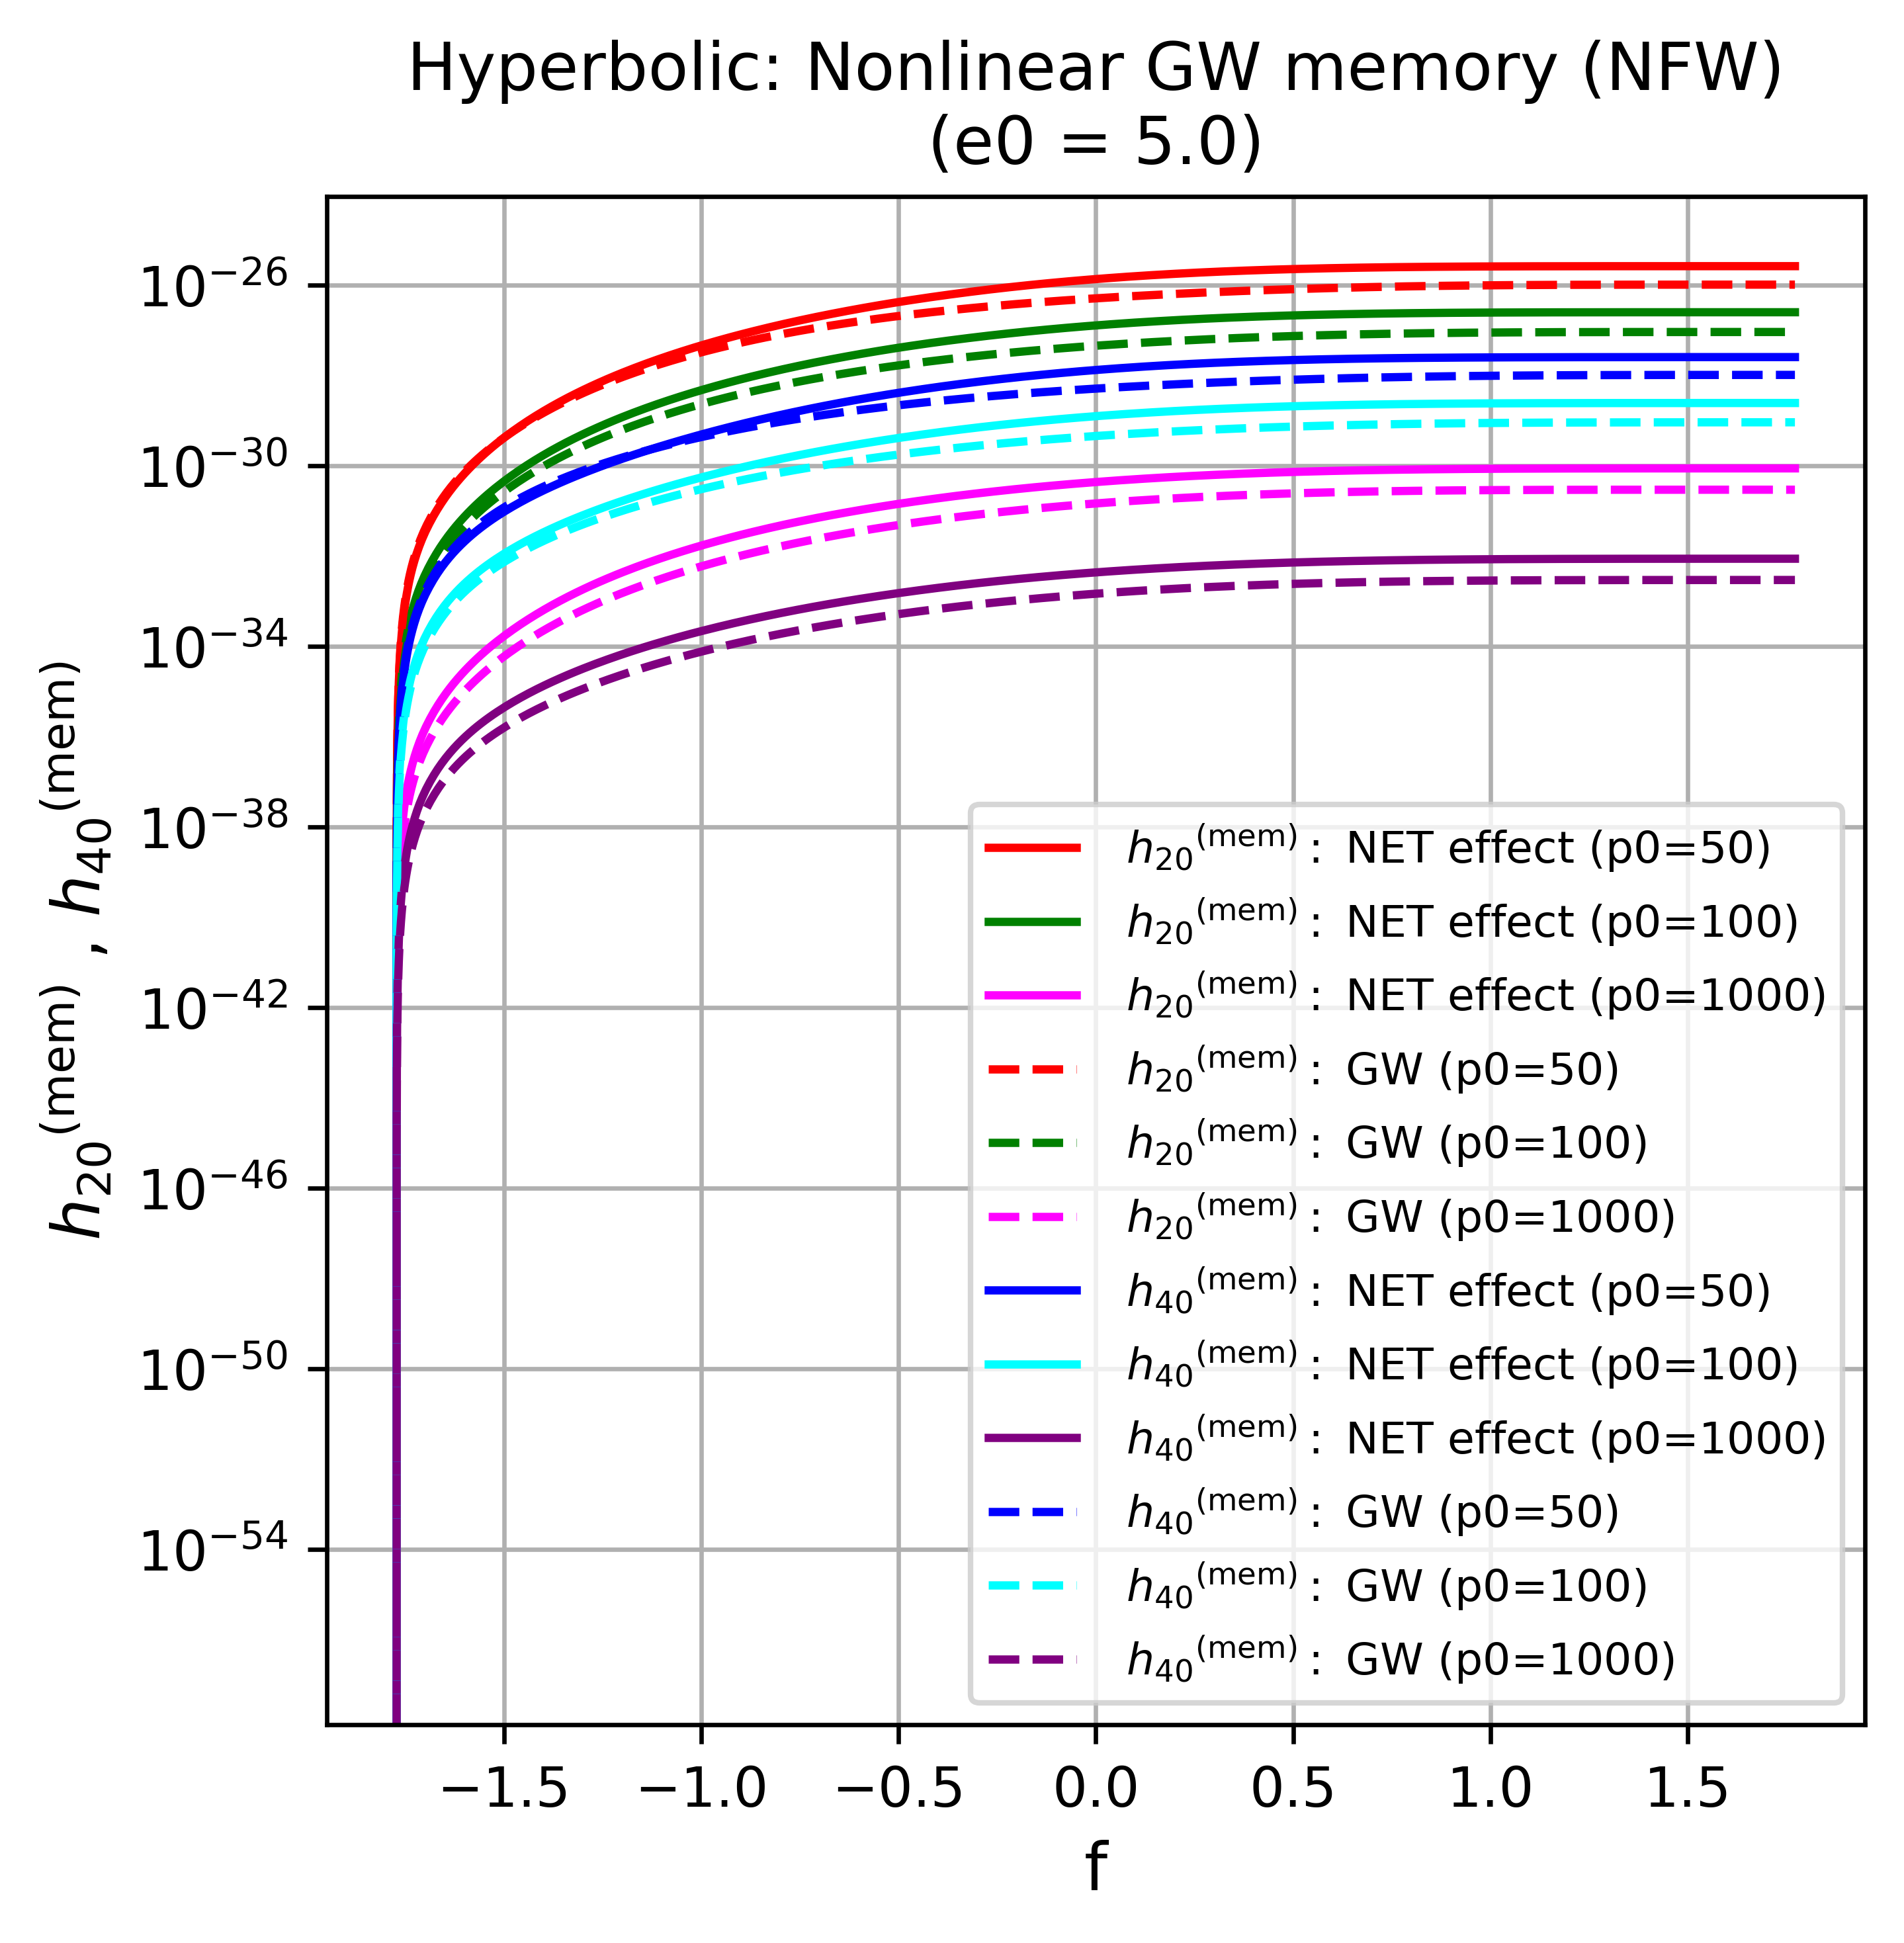

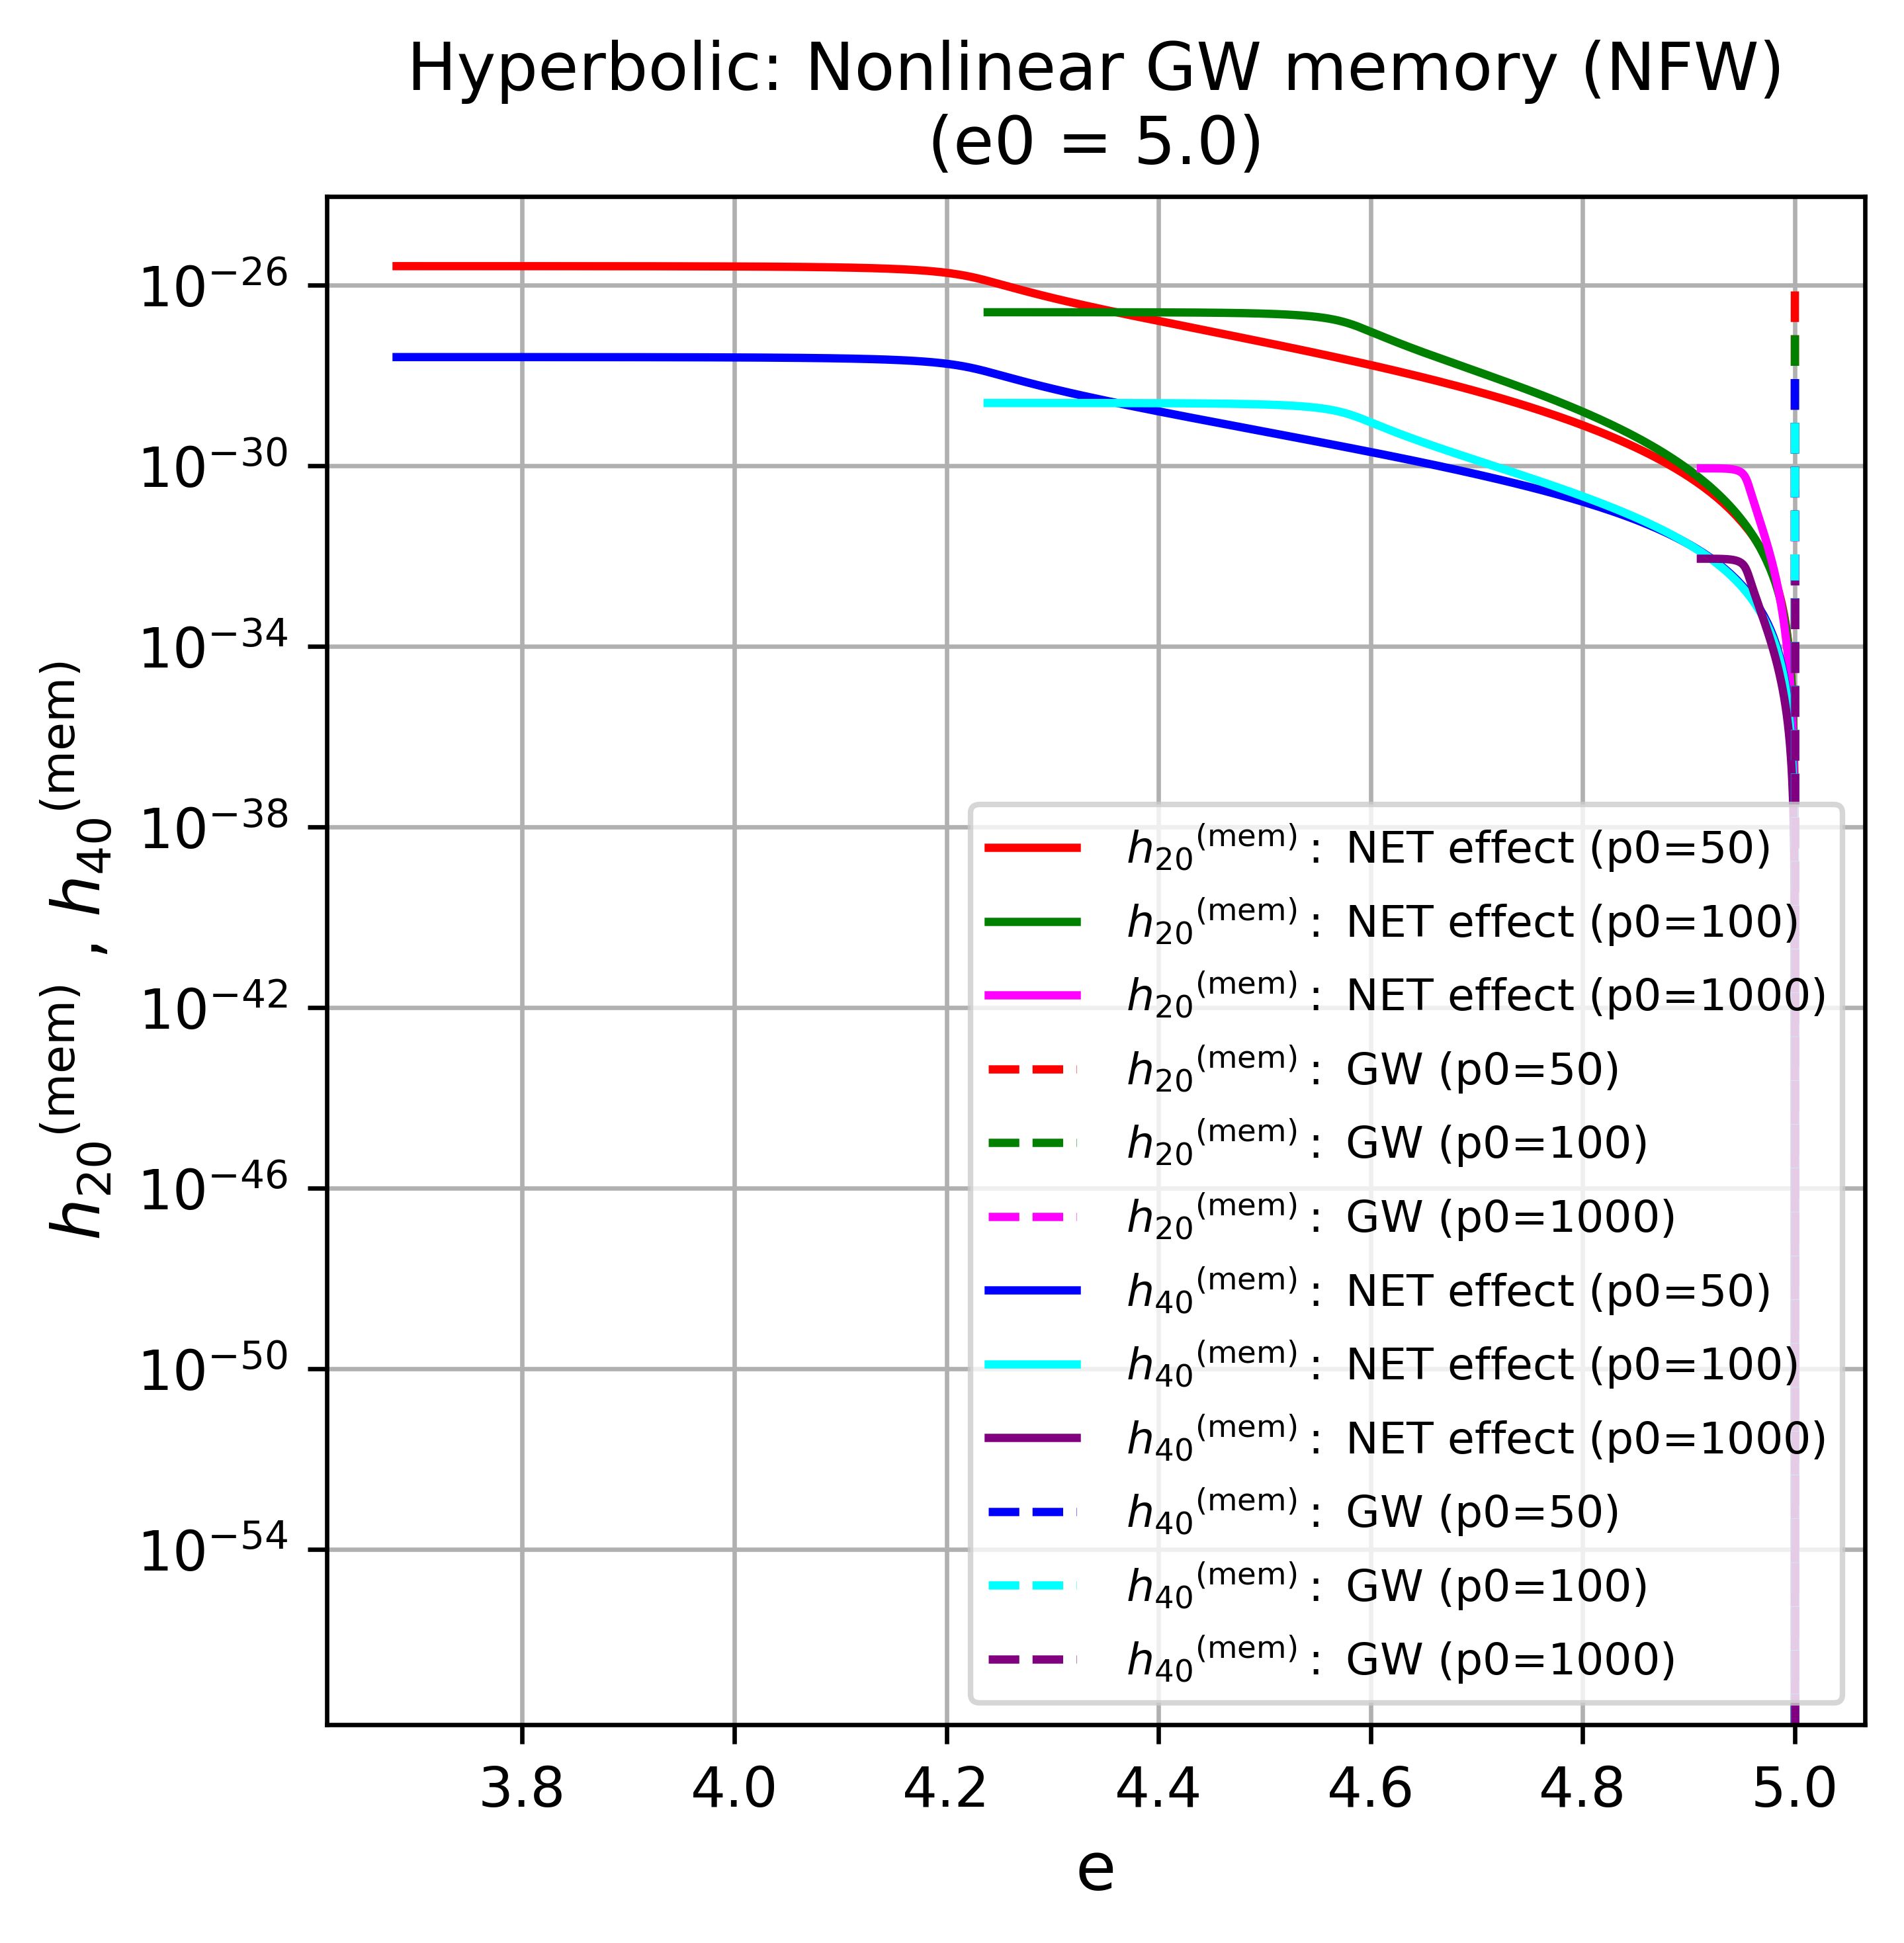

In [28]:
def hyperbolic_nonlinear_memo_diff_init_p(e_0, p_initials, omega_0, t_0, R):
    # initial semi-latus rectum values
    p0_1 = p_initials[0] 
    p0_2 = p_initials[1] 
    p0_3 = p_initials[2] 

    # Calculating Nonlinear GW memory for given initial orbital parameters
    hyperbolic_nonlinear_memory1 = hyperbolic_calculate_nonlinear_memory_NFW(e_0, p0_1, omega_0, t_0, R)
    hyperbolic_nonlinear_memory2 = hyperbolic_calculate_nonlinear_memory_NFW(e_0, p0_2, omega_0, t_0, R)
    hyperbolic_nonlinear_memory3 = hyperbolic_calculate_nonlinear_memory_NFW(e_0, p0_3, omega_0, t_0, R)
    
    # Only GW backreaction
    fgw1, ygw1, h20_mem_gw1, h40_mem_gw1 = hyperbolic_nonlinear_memory1.cal_hl0(val=2.5, combination=0)
    fgw2, ygw2, h20_mem_gw2, h40_mem_gw2 = hyperbolic_nonlinear_memory2.cal_hl0(val=2.5, combination=0)
    fgw3, ygw3, h20_mem_gw3, h40_mem_gw3 = hyperbolic_nonlinear_memory3.cal_hl0(val=2.5, combination=0)
    
    # NET : DM gravity + DF + Accretion + GW brxn
    f_net1, y_net1, h20_mem_NET1, h40_mem_NET1 = hyperbolic_nonlinear_memory1.cal_hl0(val=0, combination=3)
    f_net2, y_net2, h20_mem_NET2, h40_mem_NET2 = hyperbolic_nonlinear_memory2.cal_hl0(val=0, combination=3)
    f_net3, y_net3, h20_mem_NET3, h40_mem_NET3 = hyperbolic_nonlinear_memory3.cal_hl0(val=0, combination=3)

    # Plotting Nonlinear memory VS True anomaly
    plt.figure(figsize=(5,5))
    plt.title('Hyperbolic: Nonlinear GW memory (NFW)' + "\n" + f'(e0 = {e_0})')
    
    plt.plot( f_net1, h20_mem_NET1, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_1})', linestyle='-', color='red' )
    plt.plot( f_net2, h20_mem_NET2, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_2})', linestyle='-', color='green' )
    plt.plot( f_net3, h20_mem_NET3, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_3})', linestyle='-', color='magenta' )
    
    plt.plot( fgw1, h20_mem_gw1, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (p0={p0_1})', linestyle='--', color='red')
    plt.plot( fgw2, h20_mem_gw2, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (p0={p0_2})', linestyle='--', color='green')
    plt.plot( fgw3, h20_mem_gw3, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (p0={p0_3})', linestyle='--', color='magenta')
    
    plt.plot( f_net1, h40_mem_NET1, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_1})', linestyle='-', color='blue' )
    plt.plot( f_net2, h40_mem_NET2, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_2})', linestyle='-', color='cyan' )
    plt.plot( f_net3, h40_mem_NET3, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_3})', linestyle='-', color='purple' )
    
    plt.plot( fgw1, h40_mem_gw1, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (p0={p0_1})', linestyle='--', color='blue')
    plt.plot( fgw2, h40_mem_gw2, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (p0={p0_2})', linestyle='--', color='cyan')
    plt.plot( fgw3, h40_mem_gw3, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (p0={p0_3})', linestyle='--', color='purple')
    
    plt.xlabel('f')
    plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Save as PDF
    plt.savefig("hyperbolic_NFW_plot_8.pdf", format="pdf", bbox_inches="tight")

    plt.show()
        
    # Plotting Nonlinear memory VS eccentricity
    plt.figure(figsize=(5,5))
    plt.title('Hyperbolic: Nonlinear GW memory (NFW)' + "\n" + f'(e0 = {e_0})')
    
    plt.plot( y_net1[0,:], h20_mem_NET1, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_1})', linestyle='-', color='red' )
    plt.plot( y_net2[0,:], h20_mem_NET2, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_2})', linestyle='-', color='green' )
    plt.plot( y_net3[0,:], h20_mem_NET3, label = r' ${h_{20}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_3})', linestyle='-', color='magenta' )
    
    plt.plot( ygw1[0,:], h20_mem_gw1, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (p0={p0_1})', linestyle='--', color='red')
    plt.plot( ygw2[0,:], h20_mem_gw2, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (p0={p0_2})', linestyle='--', color='green')
    plt.plot( ygw3[0,:], h20_mem_gw3, label= r' ${h_{20}}^{\text{(mem)}}: $' + f' GW (p0={p0_3})', linestyle='--', color='magenta')
    
    plt.plot( y_net1[0,:], h40_mem_NET1, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_1})', linestyle='-', color='blue' )
    plt.plot( y_net2[0,:], h40_mem_NET2, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_2})', linestyle='-', color='cyan' )
    plt.plot( y_net3[0,:], h40_mem_NET3, label = r' ${h_{40}}^{\text{(mem)}}:$' +f' NET effect (p0={p0_3})', linestyle='-', color='purple' )
    
    plt.plot( ygw1[0,:], h40_mem_gw1, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (p0={p0_1})', linestyle='--', color='blue')
    plt.plot( ygw2[0,:], h40_mem_gw2, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (p0={p0_2})', linestyle='--', color='cyan')
    plt.plot( ygw3[0,:], h40_mem_gw3, label= r' ${h_{40}}^{\text{(mem)}}: $' + f' GW (p0={p0_3})', linestyle='--', color='purple')
    
    plt.xlabel('e')
    plt.ylabel(r' ${h_{20}}^{\text{(mem)}}$ , ${h_{40}}^{\text{(mem)}}$')
    # plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Save as PDF
    plt.savefig("hyperbolic_NFW_plot_9.pdf", format="pdf", bbox_inches="tight")

    plt.show()

# Initial orbital parameters
p_initials = [50, 100, 1000] # initial semi-latus rectum values
e0, t0 = 5.0, 0.0
omega0 = round(np.arccos(-1/e0),2)

# Plotting Nonlinear memory for three-different initial semi-latus rectum values
hyperbolic_nonlinear_memo_diff_init_p(e0, p_initials, omega0, t0, R)